# Predicting Stock Prices using Long Short-Term Memory (LSTM)

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import yfinance as yahoo_Finance_data

# Importing the libraries

from pandas_datareader import data

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import itertools
import random
import os
import datetime as dt
import urllib.request, json
import pandas_profiling as pp
import datetime

from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras_tuner as kt

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import keras


import tensorflow as tf
from tensorflow.keras.layers import Dropout
import tensorflow.keras.backend as Kb


import yfinance as yahoo_Finance_data
from statistics import mean 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller



In [3]:
import numpy as np
import tensorflow as tf
import random as python_random

def reset_seeds():
   np.random.seed(123) 
   python_random.seed(123)
   tf.random.set_seed(1234)

reset_seeds()

## 1. Data preprocessing <a class="anchor" id="chapter1"></a>
### a. Upload and plot data <a class="anchor" id="section_1_1"></a>

In [4]:
# in order to specify start date and
# end date we need datetime package
import datetime
 
# startDate , as per our convenience we can modify
Date_start = datetime.datetime(2005, 7, 12)
 
# endDate , as per our convenience we can modify
Date_end = datetime.datetime(2023, 8, 10)
Data_YesBank = yahoo_Finance_data.Ticker("YESBANK.NS")
 
# pass the parameters as the taken dates for start and end
stock_data=Data_YesBank.history(start=Date_start,end=Date_end).iloc[:,0:4]
stock_data.head()

,Open,High,Low,Close
Date,,,,
2005-07-12,11.748900,12.479863,10.697026,10.848567
2005-07-13,10.875311,11.231879,10.242404,10.465259
2005-07-14,10.697026,10.697026,10.162174,10.206745
2005-07-15,10.028463,11.490390,10.028463,11.026852
2005-07-18,11.178391,11.713243,11.142734,11.427988


In [5]:
stock_data.tail()

,Open,High,Low,Close
Date,,,,
2023-08-03,17.000000,17.10,16.900000,17.000000
2023-08-04,17.049999,17.15,16.900000,16.950001
2023-08-07,17.000000,17.15,16.750000,16.900000
2023-08-08,16.900000,17.00,16.750000,16.850000
2023-08-09,16.900000,17.00,16.799999,16.950001


In [13]:
#Use pandas profiling to generate the data profile report and display as widgets
Data_report=pp.ProfileReport(stock_data)
Data_report.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
#Save the report to local machine as html file
Data_report.to_file(output_file="YesBankdataAnalysisReport.html")

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Yes Bank stock closing price')

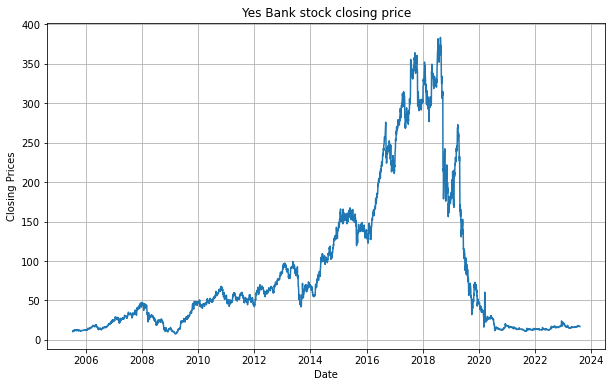

In [6]:
# Plot closing prices
Data_YesBank_ClosePrice = stock_data[['Close']]

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(Data_YesBank_ClosePrice)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('Yes Bank stock closing price')

In [7]:

def create_input_target(df):
    
    df.rename(columns = {'Close':'Input_1'}, inplace = True)
    df1=df.iloc[1:,:]
    df1.rename(columns = {'Input_1':'Input_2'}, inplace = True)
    df2=df1.iloc[1:,:]
    df2.rename(columns = {'Input_2':'Input_3'}, inplace = True)
    df3=df2.iloc[1:,:]
    df3.rename(columns = {'Input_3':'Target'}, inplace = True)

    df_actual=pd.DataFrame(pd.concat([df,df1,df2,df3],axis=1))
    df_actual['Input_2']=df_actual['Input_2'].shift(-1)
    df_actual['Input_3']=df_actual['Input_3'].shift(-2)
    df_actual['Target']=df_actual['Target'].shift(-3)

    df_actual=pd.DataFrame(df_actual.iloc[:-3,:])
    df_actual=df_actual.reset_index()
    return df_actual
df_actual= create_input_target(Data_YesBank_ClosePrice)


C:\Users\44775\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [8]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(df_actual)

dates.shape, X.shape, y.shape

((4458,), (4458, 3, 1), (4458,))

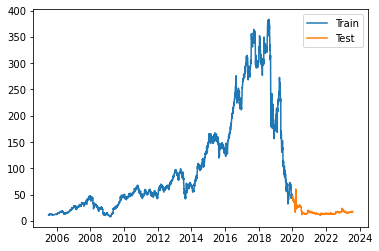

In [9]:
q_80 = int(len(dates) * .8)


dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]


dates_test, X_test, y_test = dates[q_80:], X[q_80:], y[q_80:]

plt.plot(dates_train, y_train)

plt.plot(dates_test, y_test)

plt.legend(['Train',  'Test'])

# Preprocessing again for LSTM 


In [10]:
print(X_train.shape)
print(X_test.shape)


print(y_train.shape)
print(y_test.shape)


(3566, 3, 1)
(892, 3, 1)
(3566,)
(892,)


# Multi-layer LSTM

### c. Implementing the model <a class="anchor" id="section_2_3"></a>

We implement the most simple LSTM model, the "Vanilla LSTM". This model consists in a single hidden layer of LSTM unit, and one output layer used to make predictions.

In [11]:
# ------------------LSTM----------------------
Lstm_MultiLayer_Model = Sequential()
Lstm_MultiLayer_Model.add(LSTM(activation='relu',units=128, return_sequences=True, 
                               input_shape=(X_train.shape[1], X_train.shape[2])))
Lstm_MultiLayer_Model.add(Dropout(0.2))

Lstm_MultiLayer_Model.add(LSTM(activation='relu',units=128, return_sequences=False))
Lstm_MultiLayer_Model.add(Dropout(0.2))

Lstm_MultiLayer_Model.add(Dense(units=1, activation='relu'))
Lstm_MultiLayer_Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.004), loss='mse', 
                              metrics=[tf.keras.metrics.RootMeanSquaredError()])

Lstm_MultiLayer_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


### d. Training and evaluating the model <a class="anchor" id="section_1_4"></a>


****************************************************************************************************************

The number of epoch for this experiment is: 10
The Batch Size is: 32
Epoch 1/10
78/78 [==============================] - ETA: 0s - loss: 271.1435 - root_mean_squared_error: 16.4664
Epoch 1: val_loss improved from inf to 114.66456, saving model to best_model_multi_layer_lstm_baseline.h5
78/78 [==============================] - 2s 8ms/step - loss: 271.1435 - root_mean_squared_error: 16.4664 - val_loss: 114.6646 - val_root_mean_squared_error: 10.7082
Epoch 2/10
75/78 [===========================>..] - ETA: 0s - loss: 73.3440 - root_mean_squared_error: 8.5641
Epoch 2: val_loss did not improve from 114.66456
78/78 [==============================] - 0s 4ms/step - loss: 75.5000 - root_mean_squared_error: 8.6891 - val_loss: 1887.0795 - val_root_mean_squared_error: 43.4405
Epoch 3/10
73/78 [===========================>..] - ETA: 0s - loss: 69.9735 - root_mean_squared_error: 8.3650


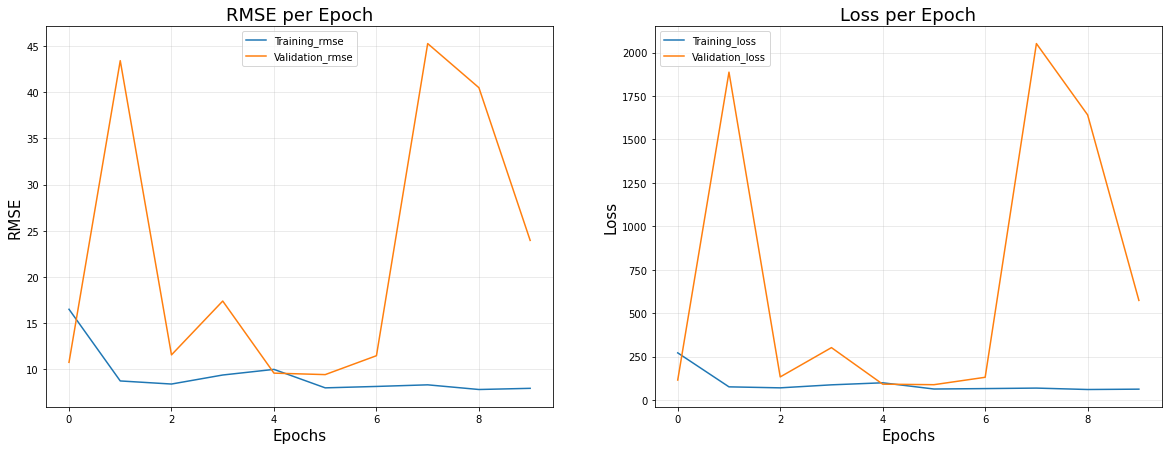

In [12]:
epochs=[10]
batch_sizes = [32]
for epoch in epochs:
    for batch_size in batch_sizes:  
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        mc = ModelCheckpoint('best_model_multi_layer_lstm_baseline.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        # fit model
        print()
        print('****************************************************************************************************************')
        print()
        print('The number of epoch for this experiment is:',epoch)
        print('The Batch Size is:',batch_size)
        Lstm_MultiLayer_Model_history = Lstm_MultiLayer_Model.fit(X_train, y_train,validation_split=0.3
                                           ,epochs=epoch, batch_size=batch_size, callbacks=[es,mc])
        print()
        print('****************************************************************************************************************')
        print('The metrics score for epoch: {0}\nBatch Size: {1}\nRMSE for training set: {2}\nRMSE forValidation set: {3}\nLoss for Training set: {4}\nLoss for Validation set: {5}'
              .format(epoch,batch_size,mean(Lstm_MultiLayer_Model_history.history['root_mean_squared_error'])
              ,mean(Lstm_MultiLayer_Model_history.history['val_root_mean_squared_error'])
              ,mean(Lstm_MultiLayer_Model_history.history['loss']), mean(Lstm_MultiLayer_Model_history.history['val_loss'])))
        
       
        
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print()
        print('Comparative plot for RMSE per epoch and Loss per epoch for training and validation sets')
        print('*****************************************************************************************************************')
        print()
        fig = plt.figure(figsize=(20,7))
        fig.add_subplot(121)

        # RMSE per Epoch
        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['root_mean_squared_error'], label = "Training_rmse")
        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['val_root_mean_squared_error'], label = "Validation_rmse")

        plt.title("RMSE per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("RMSE", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()


        #Adding Subplot 1 (For Loss)
        fig.add_subplot(122)

        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['loss'], label="Training_loss")
        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['val_loss'], label="Validation_loss")

        plt.title("Loss per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("Loss", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()

        plt.show()
       
        
       

# Experiment on the Baseline Model Multi-Layer LSTM 
# with different number of epoch and Batch Size


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 32
Epoch 1/10
76/78 [============================>.] - ETA: 0s - loss: 59.3245 - root_mean_squared_error: 7.7022
Epoch 1: val_loss improved from inf to 647.46533, saving model to best_model_multi_layer_lstm_experiment.h5
78/78 [==============================] - 0s 5ms/step - loss: 59.1235 - root_mean_squared_error: 7.6892 - val_loss: 647.4653 - val_root_mean_squared_error: 25.4453
Epoch 2/10
74/78 [===========================>..] - ETA: 0s - loss: 56.0551 - root_mean_squared_error: 7.4870
Epoch 2: val_loss improved from 647.46533 to 580.62976, saving model to best_model_multi_layer_lstm_

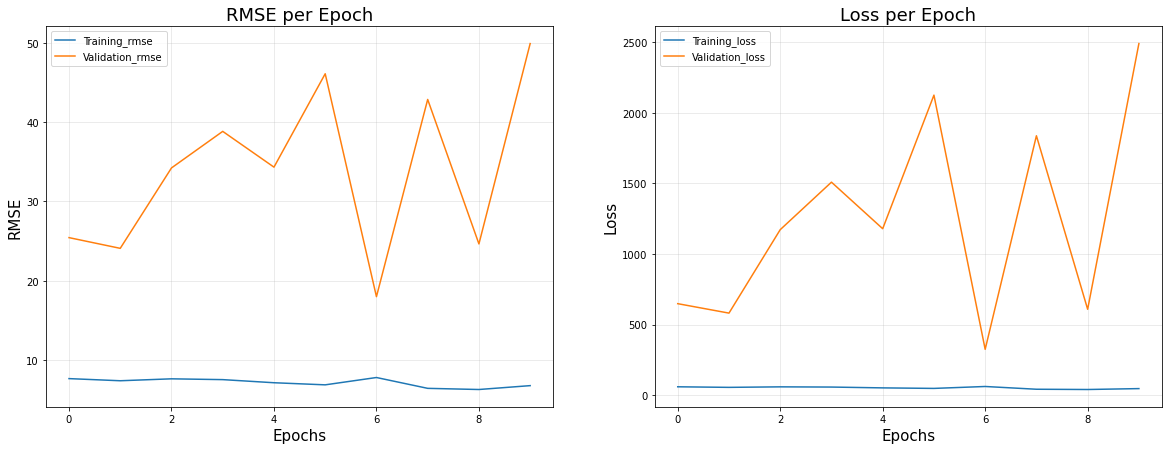


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 64
Epoch 1/10
39/39 [==============================] - ETA: 0s - loss: 41.0350 - root_mean_squared_error: 6.4059
Epoch 1: val_loss improved from inf to 1142.71924, saving model to best_model_multi_layer_lstm_experiment.h5
39/39 [==============================] - 1s 8ms/step - loss: 41.0350 - root_mean_squared_error: 6.4059 - val_loss: 1142.7192 - val_root_mean_squared_error: 33.8041
Epoch 2/10
30/39 [======================>.......] - ETA: 0s - loss: 33.8683 - root_mean_squared_error: 5.8196
Epoch 2: val_loss did not improve from 1142.71924
39/39 [==============================] - 0s 7ms/

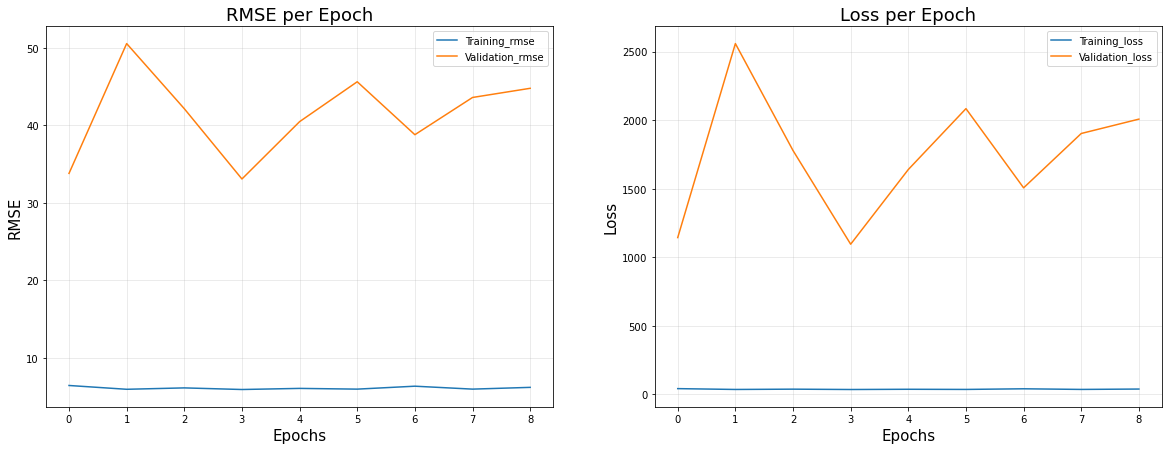


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 128
Epoch 1/10
15/20 [=====================>........] - ETA: 0s - loss: 34.2451 - root_mean_squared_error: 5.8519
Epoch 1: val_loss improved from inf to 1313.66565, saving model to best_model_multi_layer_lstm_experiment.h5
20/20 [==============================] - 0s 12ms/step - loss: 34.8332 - root_mean_squared_error: 5.9020 - val_loss: 1313.6656 - val_root_mean_squared_error: 36.2445
Epoch 2/10
15/20 [=====================>........] - ETA: 0s - loss: 33.8998 - root_mean_squared_error: 5.8224
Epoch 2: val_loss did not improve from 1313.66565
20/20 [==============================] - 0s 9m

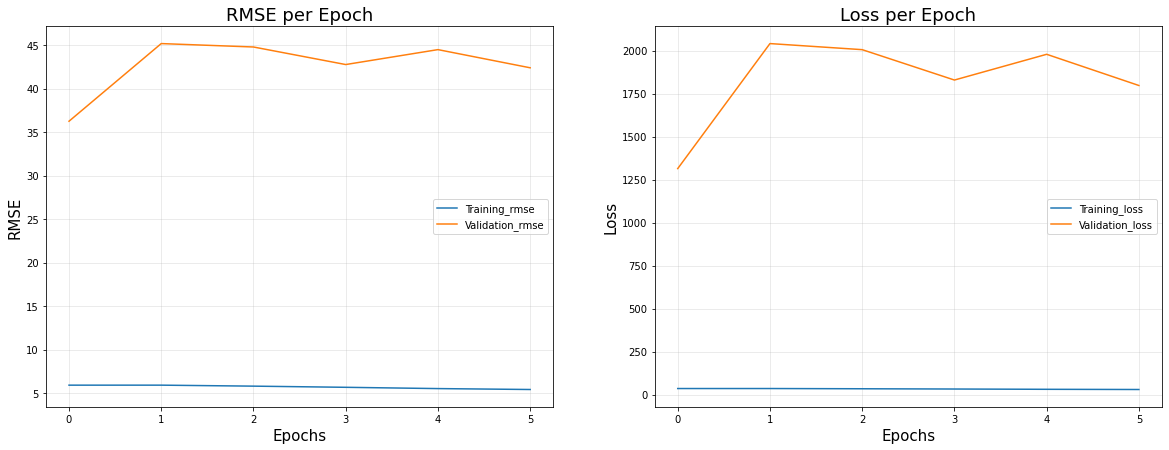


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 256
Epoch 1/10
 7/10 [====================>.........] - ETA: 0s - loss: 30.4452 - root_mean_squared_error: 5.5177
Epoch 1: val_loss improved from inf to 2133.58301, saving model to best_model_multi_layer_lstm_experiment.h5
10/10 [==============================] - 0s 17ms/step - loss: 29.3775 - root_mean_squared_error: 5.4201 - val_loss: 2133.5830 - val_root_mean_squared_error: 46.1907
Epoch 2/10
 7/10 [====================>.........] - ETA: 0s - loss: 31.8308 - root_mean_squared_error: 5.6419
Epoch 2: val_loss improved from 2133.58301 to 1826.15930, saving model to best_model_multi_layer

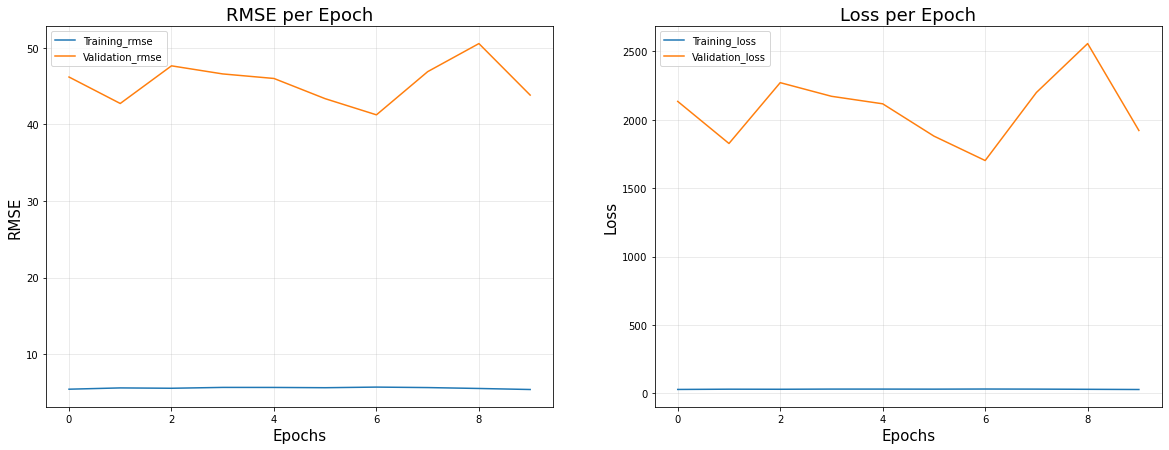


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 32
Epoch 1/20
71/78 [==========================>...] - ETA: 0s - loss: 39.9413 - root_mean_squared_error: 6.3199
Epoch 1: val_loss improved from inf to 2013.40955, saving model to best_model_multi_layer_lstm_experiment.h5
78/78 [==============================] - 0s 5ms/step - loss: 39.3311 - root_mean_squared_error: 6.2715 - val_loss: 2013.4095 - val_root_mean_squared_error: 44.8710
Epoch 2/20
78/78 [==============================] - ETA: 0s - loss: 37.3794 - root_mean_squared_error: 6.1139
Epoch 2: val_loss improved from 2013.40955 to 1696.33655, saving model to best_model_multi_layer_l

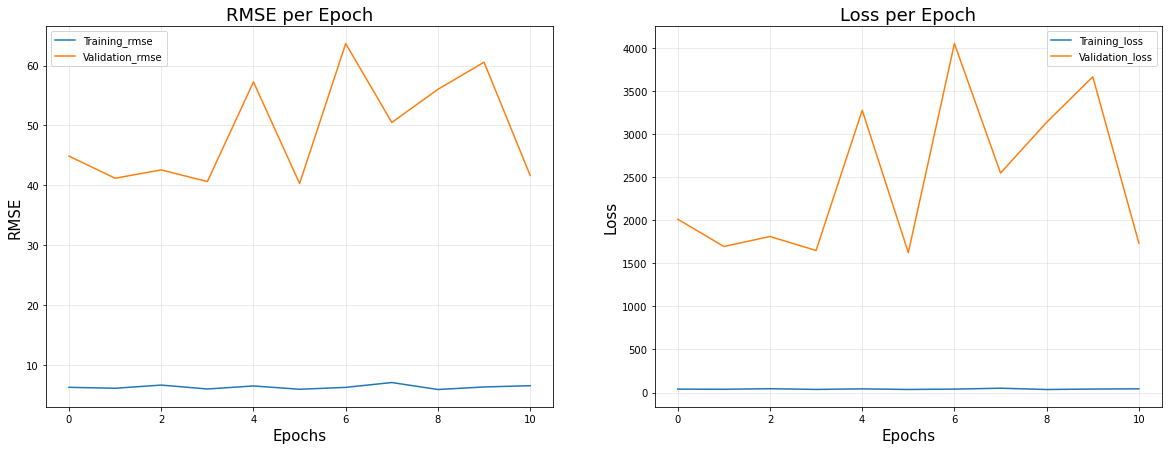


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 64
Epoch 1/20
37/39 [===========================>..] - ETA: 0s - loss: 33.3694 - root_mean_squared_error: 5.7766
Epoch 1: val_loss improved from inf to 1878.68542, saving model to best_model_multi_layer_lstm_experiment.h5
39/39 [==============================] - 0s 10ms/step - loss: 33.9932 - root_mean_squared_error: 5.8304 - val_loss: 1878.6854 - val_root_mean_squared_error: 43.3438
Epoch 2/20
38/39 [============================>.] - ETA: 0s - loss: 32.9108 - root_mean_squared_error: 5.7368
Epoch 2: val_loss did not improve from 1878.68542
39/39 [==============================] - 0s 8ms

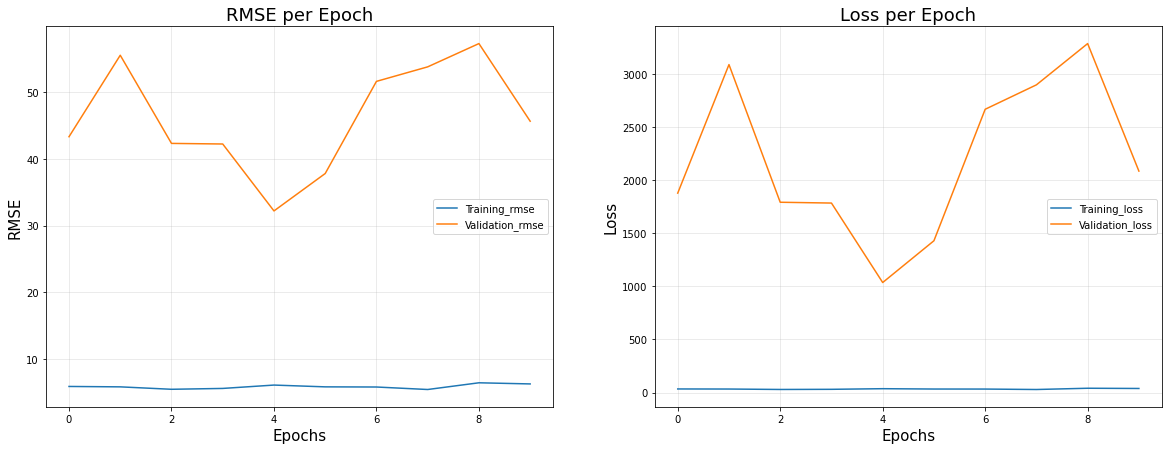


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 128
Epoch 1/20
15/20 [=====================>........] - ETA: 0s - loss: 28.9638 - root_mean_squared_error: 5.3818
Epoch 1: val_loss improved from inf to 2329.20972, saving model to best_model_multi_layer_lstm_experiment.h5
20/20 [==============================] - 0s 12ms/step - loss: 28.7287 - root_mean_squared_error: 5.3599 - val_loss: 2329.2097 - val_root_mean_squared_error: 48.2619
Epoch 2/20
15/20 [=====================>........] - ETA: 0s - loss: 31.0924 - root_mean_squared_error: 5.5761
Epoch 2: val_loss did not improve from 2329.20972
20/20 [==============================] - 0s 9m

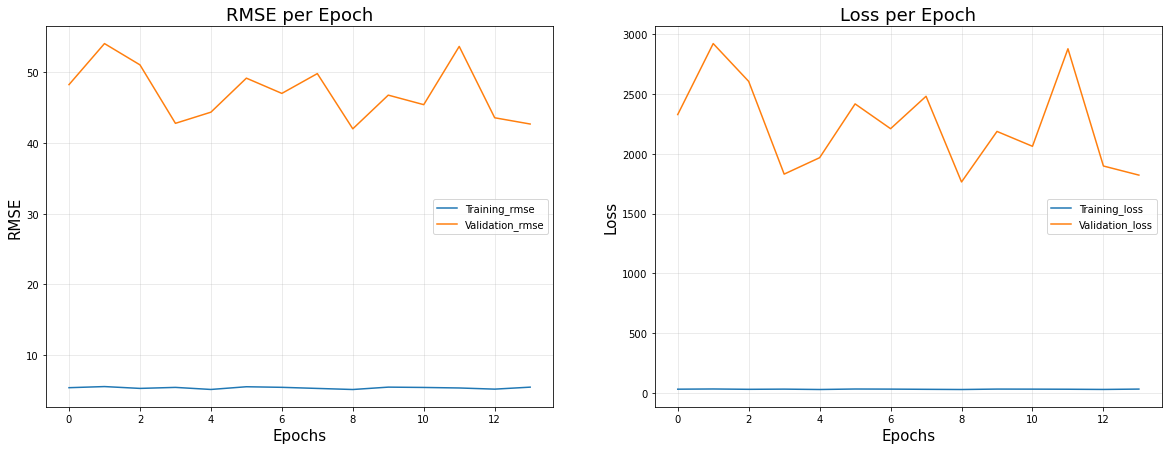


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 256
Epoch 1/20
 7/10 [====================>.........] - ETA: 0s - loss: 28.4769 - root_mean_squared_error: 5.3364
Epoch 1: val_loss improved from inf to 2238.65137, saving model to best_model_multi_layer_lstm_experiment.h5
10/10 [==============================] - 0s 18ms/step - loss: 27.9606 - root_mean_squared_error: 5.2878 - val_loss: 2238.6514 - val_root_mean_squared_error: 47.3144
Epoch 2/20
 7/10 [====================>.........] - ETA: 0s - loss: 27.3666 - root_mean_squared_error: 5.2313
Epoch 2: val_loss improved from 2238.65137 to 2172.51025, saving model to best_model_multi_layer

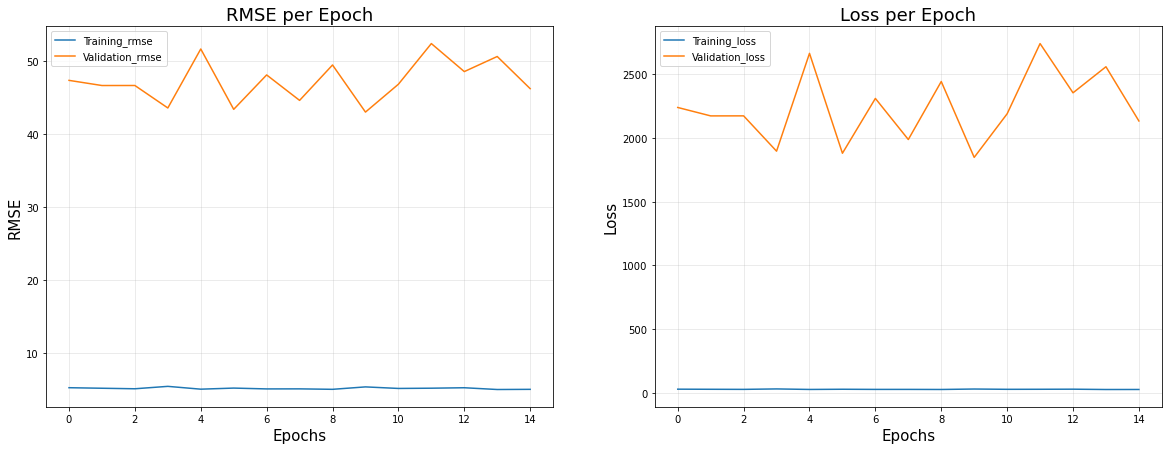


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 32
Epoch 1/50
71/78 [==========================>...] - ETA: 0s - loss: 28.7223 - root_mean_squared_error: 5.3593
Epoch 1: val_loss improved from inf to 2400.64990, saving model to best_model_multi_layer_lstm_experiment.h5
78/78 [==============================] - 0s 5ms/step - loss: 28.2644 - root_mean_squared_error: 5.3164 - val_loss: 2400.6499 - val_root_mean_squared_error: 48.9964
Epoch 2/50
75/78 [===========================>..] - ETA: 0s - loss: 40.5608 - root_mean_squared_error: 6.3687
Epoch 2: val_loss improved from 2400.64990 to 1411.47913, saving model to best_model_multi_layer_l

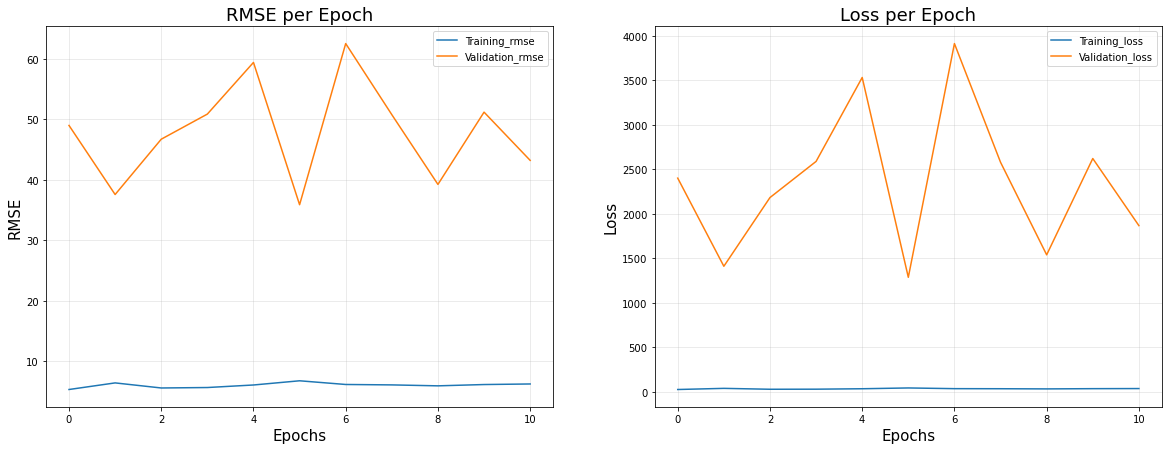


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 64
Epoch 1/50
36/39 [==========================>...] - ETA: 0s - loss: 31.8190 - root_mean_squared_error: 5.6408
Epoch 1: val_loss improved from inf to 2364.41064, saving model to best_model_multi_layer_lstm_experiment.h5
39/39 [==============================] - 0s 9ms/step - loss: 31.1235 - root_mean_squared_error: 5.5788 - val_loss: 2364.4106 - val_root_mean_squared_error: 48.6252
Epoch 2/50
35/39 [=========================>....] - ETA: 0s - loss: 30.9317 - root_mean_squared_error: 5.5616
Epoch 2: val_loss improved from 2364.41064 to 2046.43347, saving model to best_model_multi_layer_l

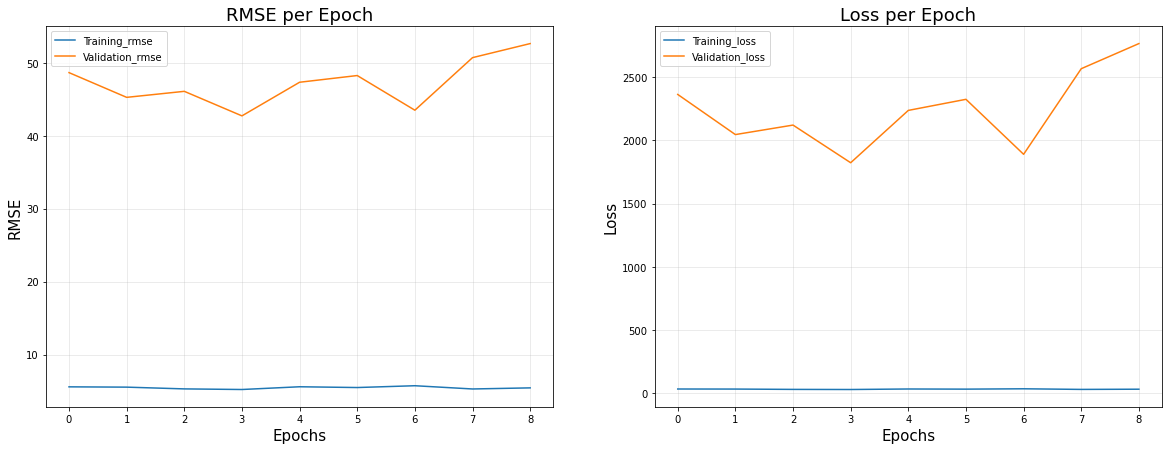


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 128
Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 30.8587 - root_mean_squared_error: 5.5551
Epoch 1: val_loss improved from inf to 2344.06665, saving model to best_model_multi_layer_lstm_experiment.h5
20/20 [==============================] - 0s 13ms/step - loss: 30.8587 - root_mean_squared_error: 5.5551 - val_loss: 2344.0667 - val_root_mean_squared_error: 48.4156
Epoch 2/50
14/20 [====================>.........] - ETA: 0s - loss: 26.7800 - root_mean_squared_error: 5.1749
Epoch 2: val_loss improved from 2344.06665 to 2288.15845, saving model to best_model_multi_layer

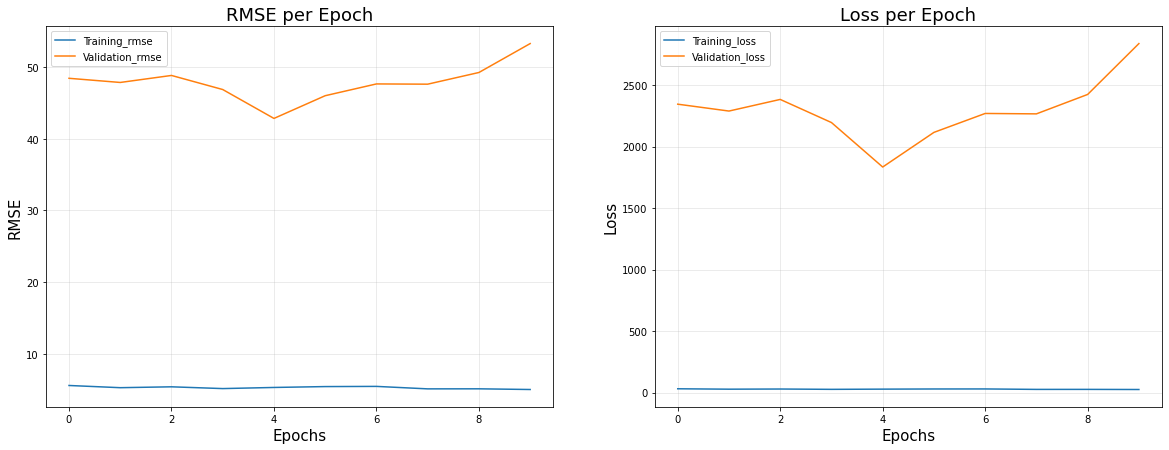


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 256
Epoch 1/50
 6/10 [=================>............] - ETA: 0s - loss: 25.1831 - root_mean_squared_error: 5.0183
Epoch 1: val_loss improved from inf to 2800.09546, saving model to best_model_multi_layer_lstm_experiment.h5
10/10 [==============================] - 0s 24ms/step - loss: 25.5306 - root_mean_squared_error: 5.0528 - val_loss: 2800.0955 - val_root_mean_squared_error: 52.9159
Epoch 2/50
 9/10 [==========================>...] - ETA: 0s - loss: 23.8699 - root_mean_squared_error: 4.8857
Epoch 2: val_loss improved from 2800.09546 to 2589.63306, saving model to best_model_multi_layer

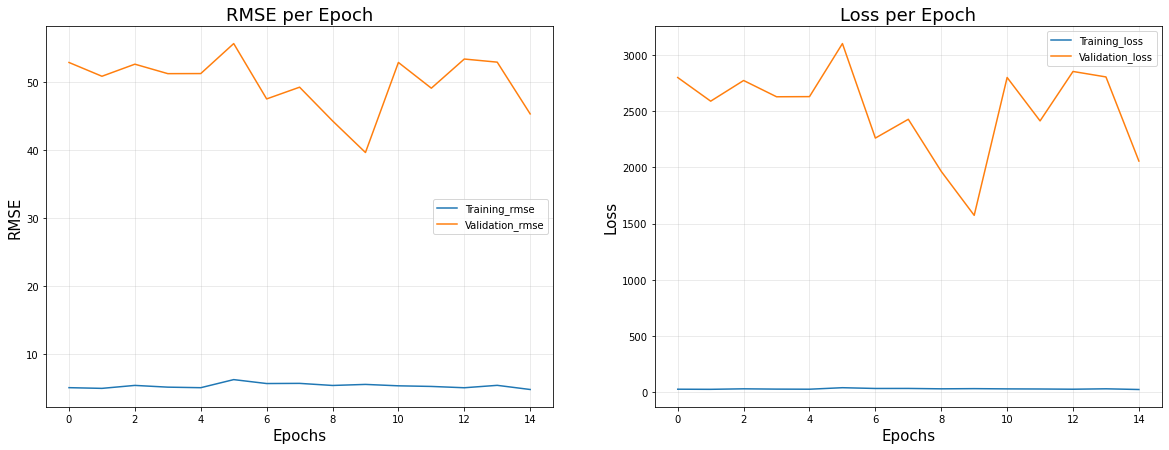


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 32
Epoch 1/100
75/78 [===========================>..] - ETA: 0s - loss: 37.1122 - root_mean_squared_error: 6.0920
Epoch 1: val_loss improved from inf to 3645.76221, saving model to best_model_multi_layer_lstm_experiment.h5
78/78 [==============================] - 0s 6ms/step - loss: 37.1675 - root_mean_squared_error: 6.0965 - val_loss: 3645.7622 - val_root_mean_squared_error: 60.3801
Epoch 2/100
69/78 [=========================>....] - ETA: 0s - loss: 32.3893 - root_mean_squared_error: 5.6912
Epoch 2: val_loss improved from 3645.76221 to 1170.59192, saving model to best_model_multi_laye

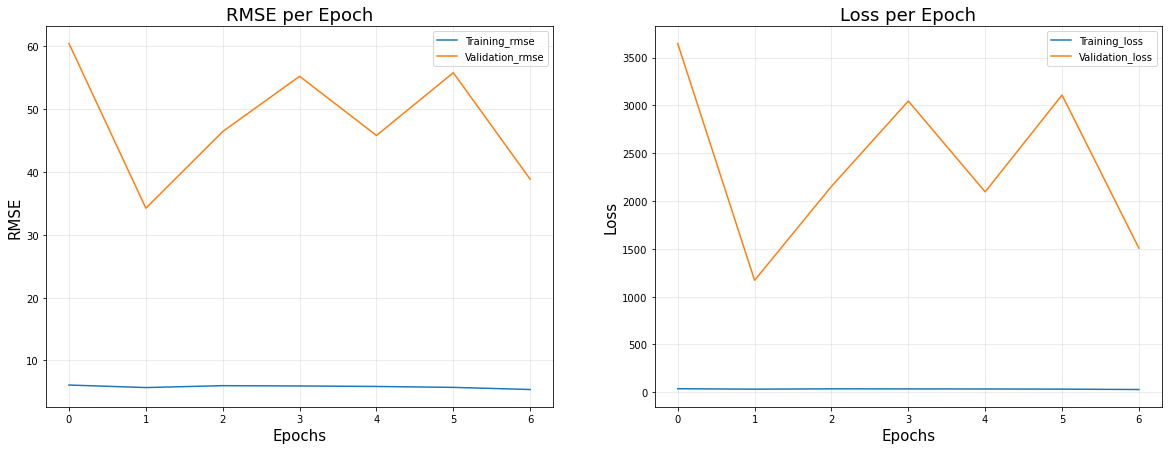


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 64
Epoch 1/100
34/39 [=========================>....] - ETA: 0s - loss: 31.8329 - root_mean_squared_error: 5.6421
Epoch 1: val_loss improved from inf to 2601.50781, saving model to best_model_multi_layer_lstm_experiment.h5
39/39 [==============================] - 0s 9ms/step - loss: 30.5111 - root_mean_squared_error: 5.5237 - val_loss: 2601.5078 - val_root_mean_squared_error: 51.0050
Epoch 2/100
32/39 [=======================>......] - ETA: 0s - loss: 29.3208 - root_mean_squared_error: 5.4149
Epoch 2: val_loss did not improve from 2601.50781
39/39 [==============================] - 0s 8

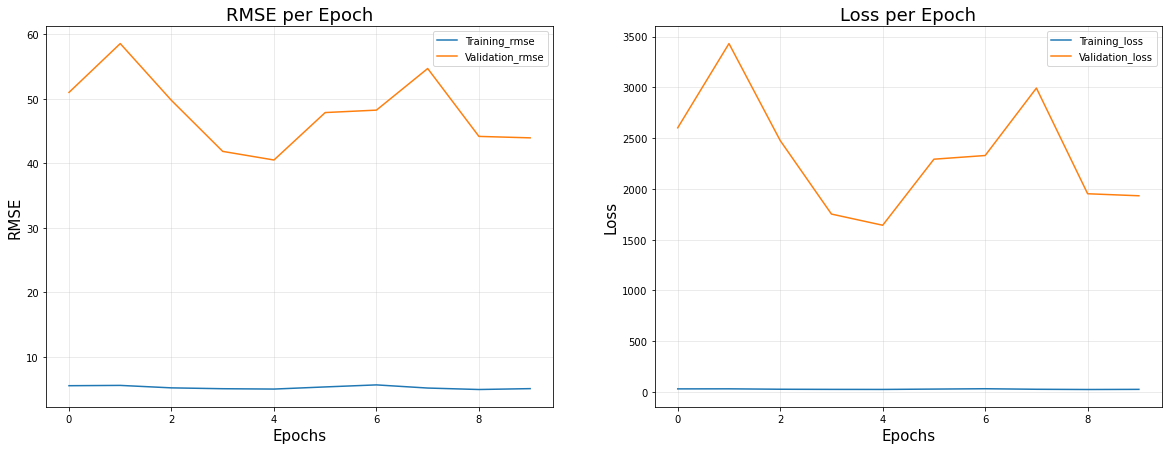


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 128
Epoch 1/100
14/20 [====================>.........] - ETA: 0s - loss: 26.3276 - root_mean_squared_error: 5.1310
Epoch 1: val_loss improved from inf to 2029.76257, saving model to best_model_multi_layer_lstm_experiment.h5
20/20 [==============================] - 0s 12ms/step - loss: 25.0637 - root_mean_squared_error: 5.0064 - val_loss: 2029.7626 - val_root_mean_squared_error: 45.0529
Epoch 2/100
15/20 [=====================>........] - ETA: 0s - loss: 23.4454 - root_mean_squared_error: 4.8420
Epoch 2: val_loss did not improve from 2029.76257
20/20 [==============================] - 0s

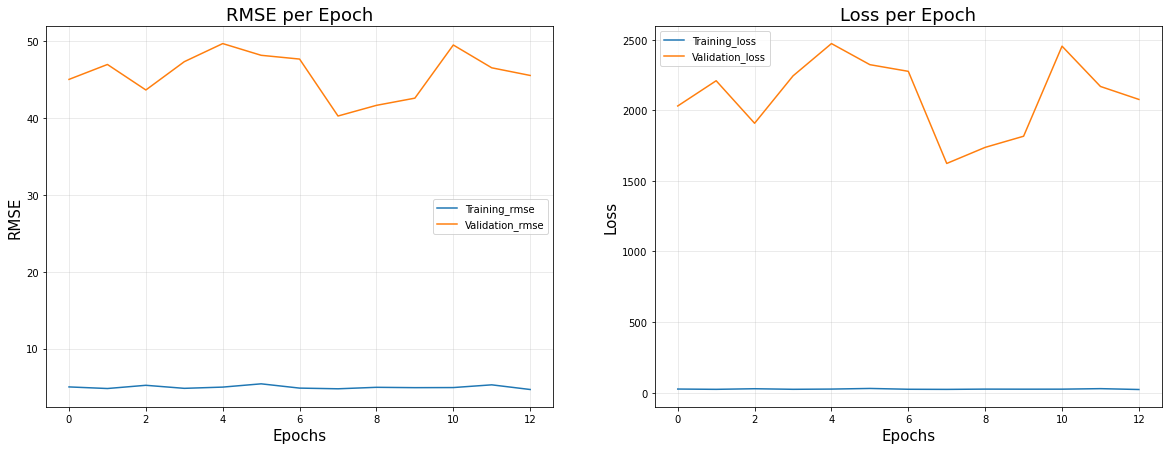


****************************************************************************************************************
****************************************************************************************************************
****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 256
Epoch 1/100
 7/10 [====================>.........] - ETA: 0s - loss: 24.3120 - root_mean_squared_error: 4.9307
Epoch 1: val_loss improved from inf to 2063.77197, saving model to best_model_multi_layer_lstm_experiment.h5
10/10 [==============================] - 0s 18ms/step - loss: 22.7662 - root_mean_squared_error: 4.7714 - val_loss: 2063.7720 - val_root_mean_squared_error: 45.4288
Epoch 2/100
 6/10 [=================>............] - ETA: 0s - loss: 23.5420 - root_mean_squared_error: 4.8520
Epoch 2: val_loss improved from 2063.77197 to 2018.47083, saving model to best_model_multi_la

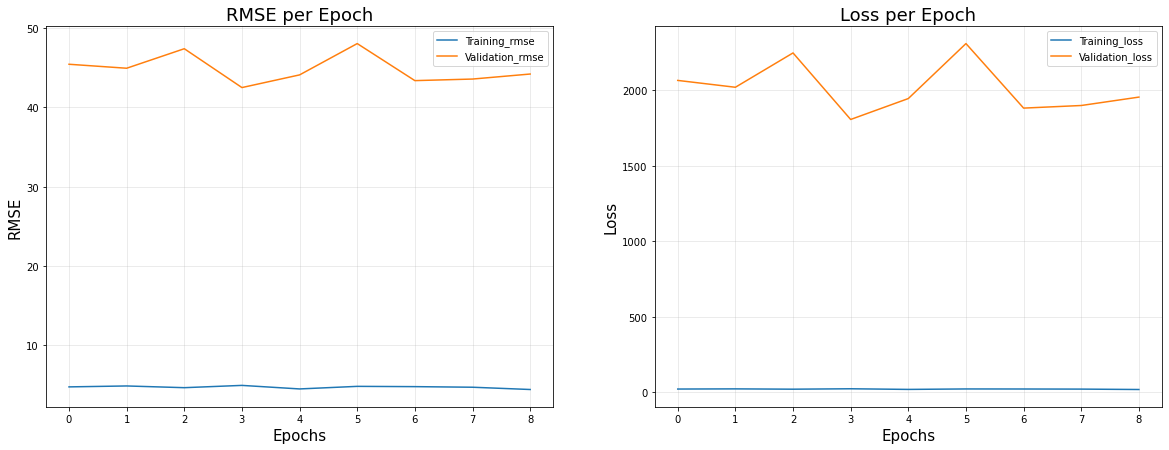

In [11]:
epochs=[10,20,50,100]
batch_sizes = [32,64,128,256]
for epoch in epochs:
    for batch_size in batch_sizes:  
       
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        mc = ModelCheckpoint('best_model_multi_layer_lstm_experiment.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        # fit model
        print()
        print('****************************************************************************************************************')
        print('****************************************************************************************************************')
        print('****************************************************************************************************************')
        print('The number of epoch for this experiment is:',epoch)
        print('The Batch Size is:',batch_size)
        Lstm_MultiLayer_Model_history = Lstm_MultiLayer_Model.fit(X_train, y_train, validation_split=0.3,
                                                                  epochs=epoch, batch_size=batch_size, callbacks=[es,mc])
        
        
        
        print()
        print('****************************************************************************************************************')
        print('The metrics score for epoch: {0}\nBatch Size: {1}\nRMSE for training set: {2}\nRMSE forValidation set: {3}\nLoss for Training set: {4}\nLoss for Validation set: {5}'
              .format(epoch,batch_size,mean(Lstm_MultiLayer_Model_history.history['root_mean_squared_error'])
              ,mean(Lstm_MultiLayer_Model_history.history['val_root_mean_squared_error'])
              ,mean(Lstm_MultiLayer_Model_history.history['loss']), mean(Lstm_MultiLayer_Model_history.history['val_loss'])))
        
       
        
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print()
        print('Comparative plot for RMSE per epoch and Loss per epoch for training and validation sets')
        print('*****************************************************************************************************************')
        print()
        
        fig = plt.figure(figsize=(20,7))
        fig.add_subplot(121)

        # RMSE per Epoch
        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['root_mean_squared_error'], label = "Training_rmse")
        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['val_root_mean_squared_error'], label = "Validation_rmse")

        plt.title("RMSE per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("RMSE", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()


        #Adding Subplot 1 (For Loss)
        fig.add_subplot(122)

        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['loss'], label="Training_loss")
        plt.plot(Lstm_MultiLayer_Model_history.epoch, Lstm_MultiLayer_Model_history.history['val_loss'], label="Validation_loss")

        plt.title("Loss per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("Loss", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()

        plt.show()
        

## 3. Single-layer LSTM 

### c. Implementing the model <a class="anchor" id="section_3_3"></a>

In [12]:
# ------------------LSTM----------------------
Lstm_SingleLayer_Model = Sequential()
Lstm_SingleLayer_Model.add(LSTM(activation='relu',units=128, return_sequences=True, 
                               input_shape=(X_train.shape[1], X_train.shape[2])))
Lstm_SingleLayer_Model.add(Dropout(0.2))

Lstm_SingleLayer_Model.add(Dense(units=1, activation='relu'))
Lstm_SingleLayer_Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.004), loss='mse', 
                              metrics=[tf.keras.metrics.RootMeanSquaredError()])

Lstm_SingleLayer_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 128)            66560     
                                                                 
 dropout_2 (Dropout)         (None, 3, 128)            0         
                                                                 
 dense_1 (Dense)             (None, 3, 1)              129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


### d. Training and evaluating the model <a class="anchor" id="section_3_4"></a>

The number of epoch for this experiment is: 10
The Batch Size is: 32
Epoch 1/10
77/78 [============================>.] - ETA: 0s - loss: 2216.2117 - root_mean_squared_error: 47.0767
Epoch 1: val_loss improved from inf to 20238.96094, saving model to best_model_single_layer_baseline.h5
78/78 [==============================] - 1s 5ms/step - loss: 2210.4214 - root_mean_squared_error: 47.0151 - val_loss: 20238.9609 - val_root_mean_squared_error: 142.7887
Epoch 2/10
55/78 [====================>.........] - ETA: 0s - loss: 1666.7219 - root_mean_squared_error: 40.8255
Epoch 2: val_loss did not improve from 20238.96094
78/78 [==============================] - 0s 3ms/step - loss: 1633.9988 - root_mean_squared_error: 40.4228 - val_loss: 22464.7852 - val_root_mean_squared_error: 150.4351
Epoch 3/10
54/78 [===================>..........] - ETA: 0s - loss: 1509.5206 - root_mean_squared_error: 38.8525
Epoch 3: val_loss did not improve from 20238.96094
78/78 [==============================] - 0s 3ms/

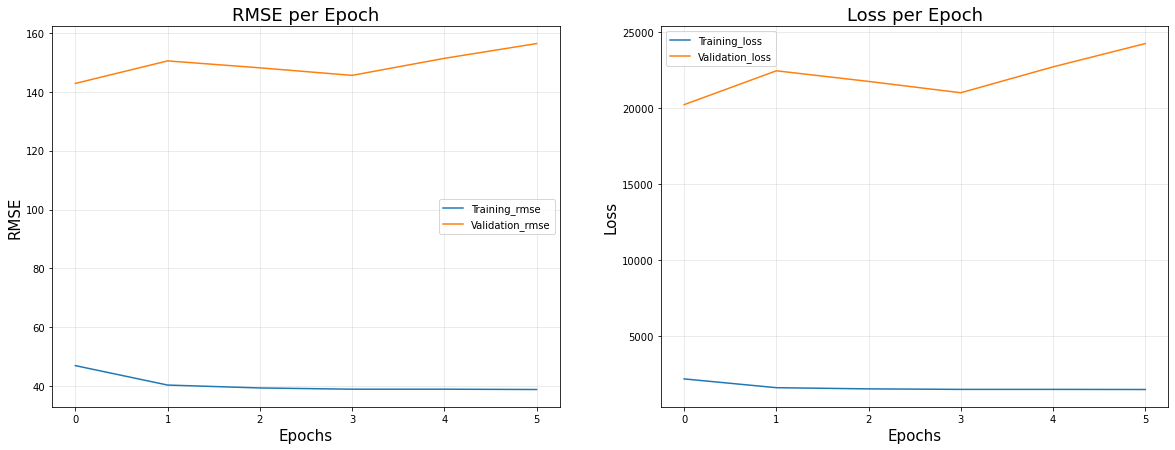

In [13]:
epochs=[10]
batch_sizes = [32]
for epoch in epochs:
    for batch_size in batch_sizes:  
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        mc = ModelCheckpoint('best_model_single_layer_baseline.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        # fit model
        print('The number of epoch for this experiment is:',epoch)
        print('The Batch Size is:',batch_size)
        Lstm_SingleLayer_Model_history = Lstm_SingleLayer_Model.fit(X_train, y_train, validation_split=0.3,
                                                                  epochs=epoch, batch_size=batch_size, callbacks=[es,mc])
        
        
        
        print()
        print('****************************************************************************************************************')
        print('The metrics score for epoch: {0}\nBatch Size: {1}\nRMSE for training set: {2}\nRMSE forValidation set: {3}\nLoss for Training set: {4}\nLoss for Validation set: {5}'
              .format(epoch,batch_size,mean(Lstm_SingleLayer_Model_history.history['root_mean_squared_error'])
              ,mean(Lstm_SingleLayer_Model_history.history['val_root_mean_squared_error'])
              ,mean( Lstm_SingleLayer_Model_history.history['loss'])
              ,mean(Lstm_SingleLayer_Model_history.history['val_loss'])))
        
       
        
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print()
        print('Comparative plot for RMSE per epoch and Loss per epoch for training and validation sets')
        print('*****************************************************************************************************************')
        print()
        
        
        
        
        fig = plt.figure(figsize=(20,7))
        fig.add_subplot(121)

        # RMSE per Epoch
        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['root_mean_squared_error'], label = "Training_rmse")
        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['val_root_mean_squared_error'], label = "Validation_rmse")

        plt.title("RMSE per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("RMSE", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()


        #Adding Subplot 1 (For Loss)
        fig.add_subplot(122)

        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['loss'], label="Training_loss")
        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['val_loss'], label="Validation_loss")

        plt.title("Loss per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("Loss", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()

        plt.show()

# Experiment on the Baseline Model Single-Layer LSTM 
# with different number of epoch and Batch Size

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 32
Epoch 1/10
55/78 [====================>.........] - ETA: 0s - loss: 1569.7085 - root_mean_squared_error: 39.6196
Epoch 1: val_loss improved from inf to 22161.36914, saving model to best_model_single_layer_lstm_experiment.h5
78/78 [==============================] - 0s 3ms/step - loss: 1520.8552 - root_mean_squared_error: 38.9981 - val_loss: 22161.3691 - val_root_mean_squared_error: 149.4149
Epoch 2/10
72/78 [==========================>...] - ETA: 0s - loss: 1498.2352 - 

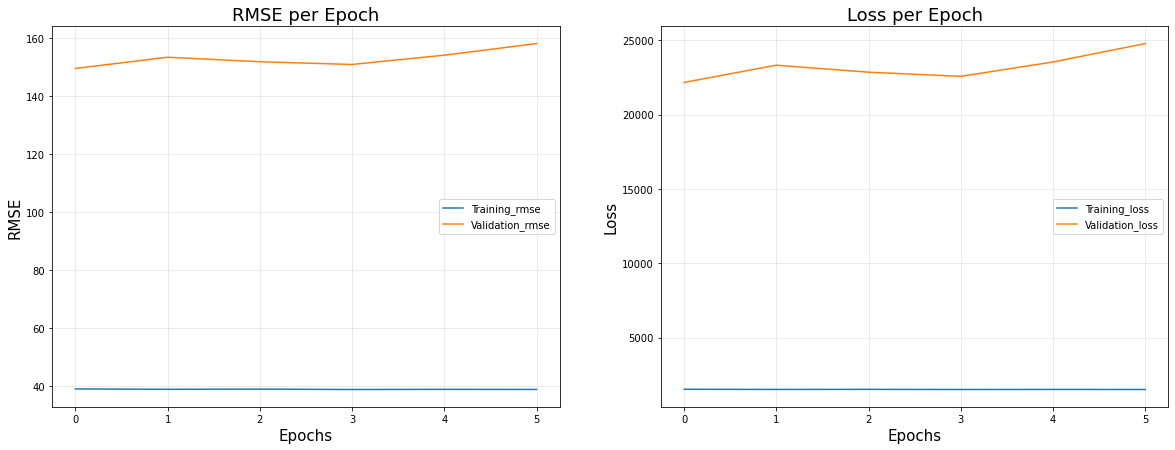

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 64
Epoch 1/10
37/39 [===========================>..] - ETA: 0s - loss: 1509.3301 - root_mean_squared_error: 38.8501
Epoch 1: val_loss improved from inf to 26868.33984, saving model to best_model_single_layer_lstm_experiment.h5
39/39 [==============================] - 1s 5ms/step - loss: 1503.1813 - root_mean_squared_error: 38.7709 - val_loss: 26868.3398 - val_root_mean_squared_error: 164.9099
Epoch 2/10
39/39 [==============================] - ETA: 0s - loss: 1502.5326 - 

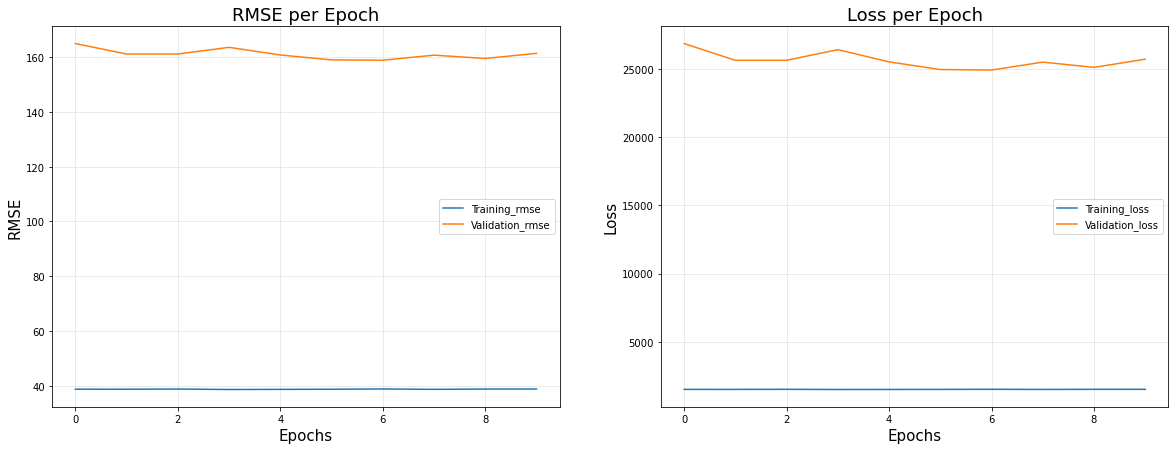

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 128
Epoch 1/10
15/20 [=====================>........] - ETA: 0s - loss: 1551.8929 - root_mean_squared_error: 39.3941
Epoch 1: val_loss improved from inf to 26429.57617, saving model to best_model_single_layer_lstm_experiment.h5
20/20 [==============================] - 0s 7ms/step - loss: 1502.0985 - root_mean_squared_error: 38.7929 - val_loss: 26429.5762 - val_root_mean_squared_error: 164.8461
Epoch 2/10
14/20 [====================>.........] - ETA: 0s - loss: 1505.9569 -

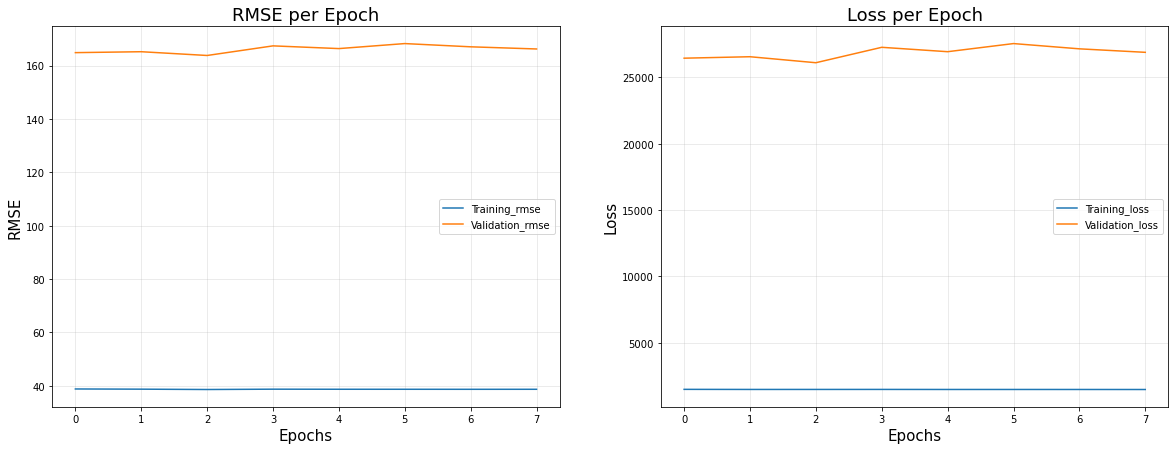

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 256
Epoch 1/10
 1/10 [==>...........................] - ETA: 0s - loss: 1688.9982 - root_mean_squared_error: 41.0974
Epoch 1: val_loss improved from inf to 28520.37891, saving model to best_model_single_layer_lstm_experiment.h5
10/10 [==============================] - 0s 12ms/step - loss: 1491.2014 - root_mean_squared_error: 38.6607 - val_loss: 28520.3789 - val_root_mean_squared_error: 171.9257
Epoch 2/10
 1/10 [==>...........................] - ETA: 0s - loss: 1712.5942 

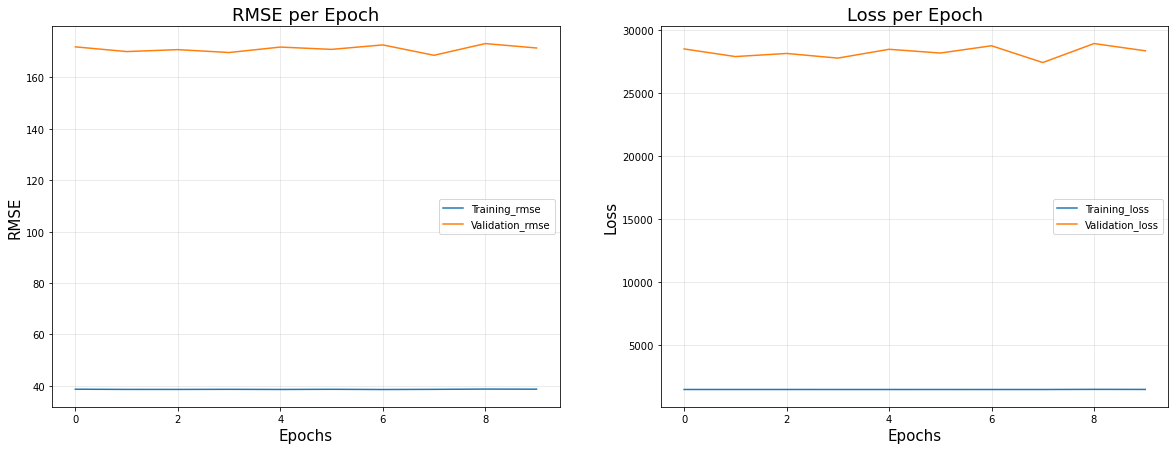

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 32
Epoch 1/20
75/78 [===========================>..] - ETA: 0s - loss: 1532.0641 - root_mean_squared_error: 39.1416
Epoch 1: val_loss improved from inf to 21349.10547, saving model to best_model_single_layer_lstm_experiment.h5
78/78 [==============================] - 0s 3ms/step - loss: 1517.9415 - root_mean_squared_error: 38.9608 - val_loss: 21349.1055 - val_root_mean_squared_error: 146.6508
Epoch 2/20
75/78 [===========================>..] - ETA: 0s - loss: 1515.1371 - 

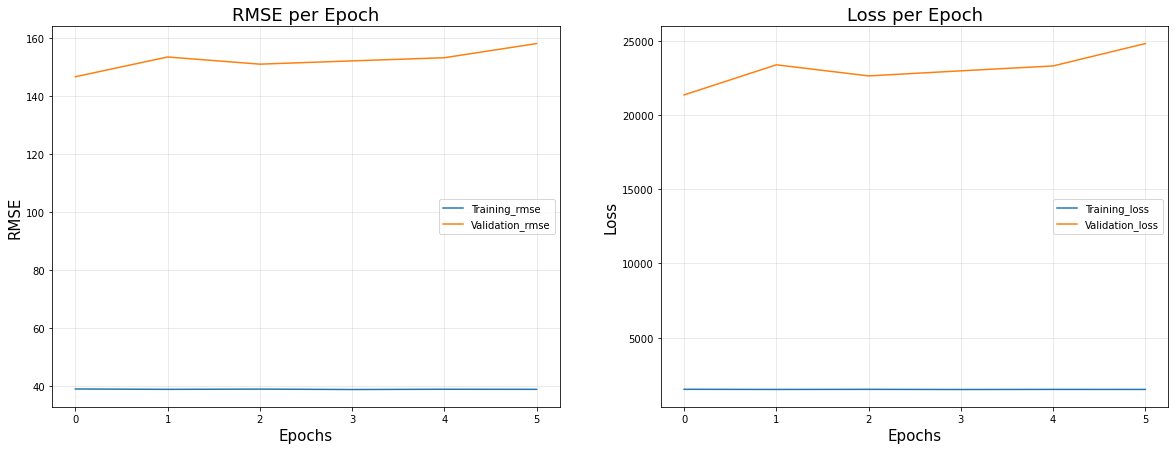

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 64
Epoch 1/20
34/39 [=========================>....] - ETA: 0s - loss: 1522.8806 - root_mean_squared_error: 39.0241
Epoch 1: val_loss improved from inf to 27358.26562, saving model to best_model_single_layer_lstm_experiment.h5
39/39 [==============================] - 0s 5ms/step - loss: 1503.1749 - root_mean_squared_error: 38.7708 - val_loss: 27358.2656 - val_root_mean_squared_error: 166.4063
Epoch 2/20
34/39 [=========================>....] - ETA: 0s - loss: 1515.1901 - 

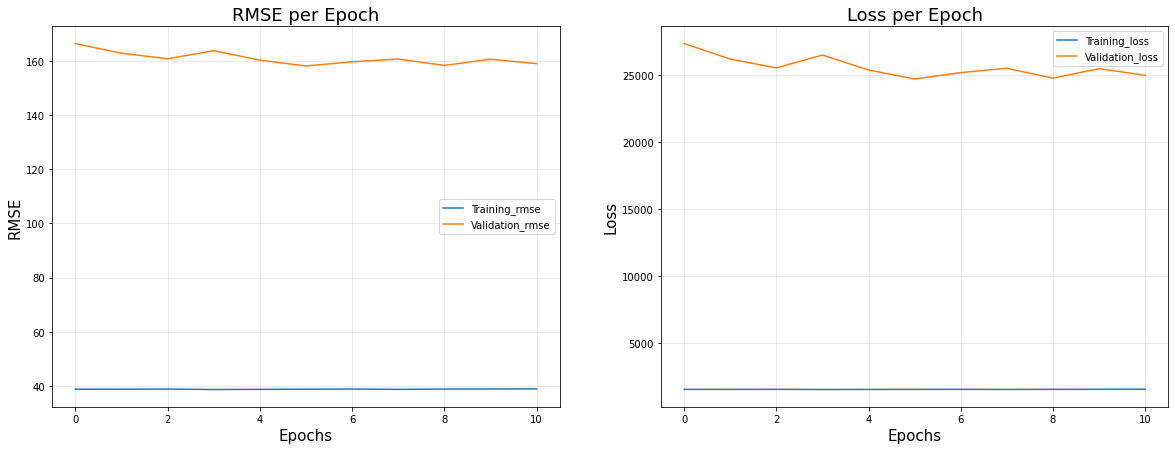

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 128
Epoch 1/20
13/20 [==================>...........] - ETA: 0s - loss: 1558.0059 - root_mean_squared_error: 39.4716
Epoch 1: val_loss improved from inf to 26539.50977, saving model to best_model_single_layer_lstm_experiment.h5
20/20 [==============================] - 0s 8ms/step - loss: 1494.0435 - root_mean_squared_error: 38.6885 - val_loss: 26539.5098 - val_root_mean_squared_error: 165.1903
Epoch 2/20
12/20 [=================>............] - ETA: 0s - loss: 1508.9150 -

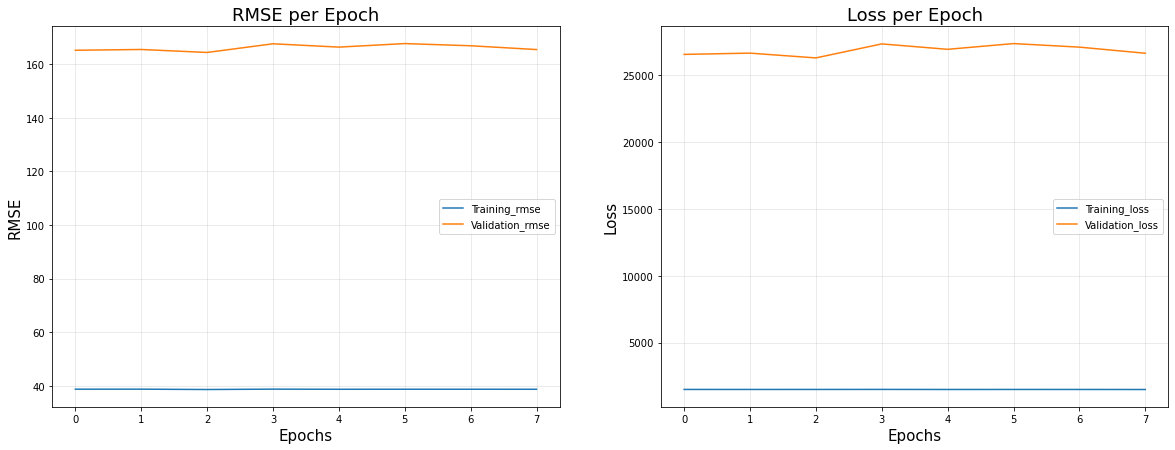

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 20
The Batch Size is: 256
Epoch 1/20
 1/10 [==>...........................] - ETA: 0s - loss: 1688.3331 - root_mean_squared_error: 41.0893
Epoch 1: val_loss improved from inf to 28510.32031, saving model to best_model_single_layer_lstm_experiment.h5
10/10 [==============================] - 0s 13ms/step - loss: 1491.0151 - root_mean_squared_error: 38.6581 - val_loss: 28510.3203 - val_root_mean_squared_error: 171.8951
Epoch 2/20
 1/10 [==>...........................] - ETA: 0s - loss: 1716.8160 

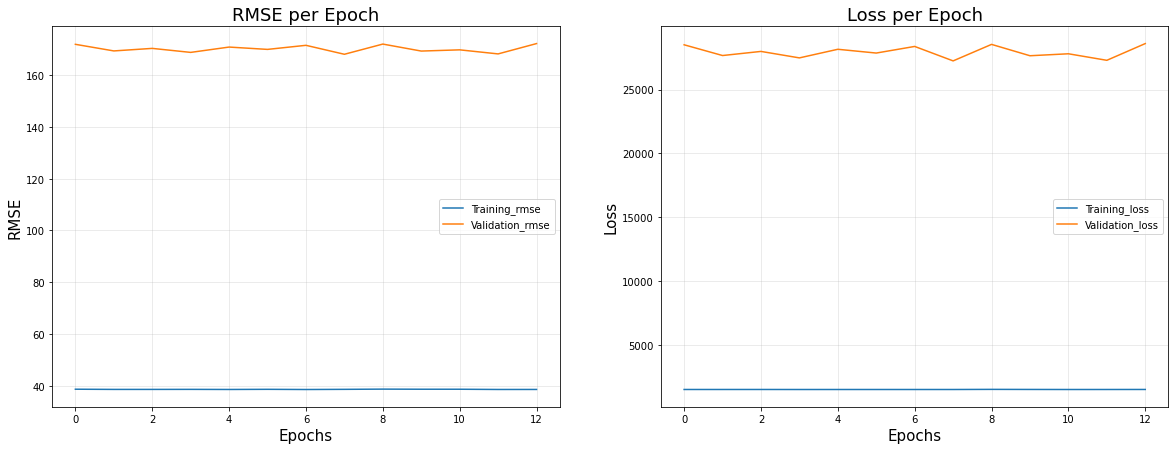

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 32
Epoch 1/50
73/78 [===========================>..] - ETA: 0s - loss: 1532.4850 - root_mean_squared_error: 39.1470
Epoch 1: val_loss improved from inf to 21871.78516, saving model to best_model_single_layer_lstm_experiment.h5
78/78 [==============================] - 0s 3ms/step - loss: 1516.5208 - root_mean_squared_error: 38.9425 - val_loss: 21871.7852 - val_root_mean_squared_error: 148.4353
Epoch 2/50
75/78 [===========================>..] - ETA: 0s - loss: 1514.0266 - 

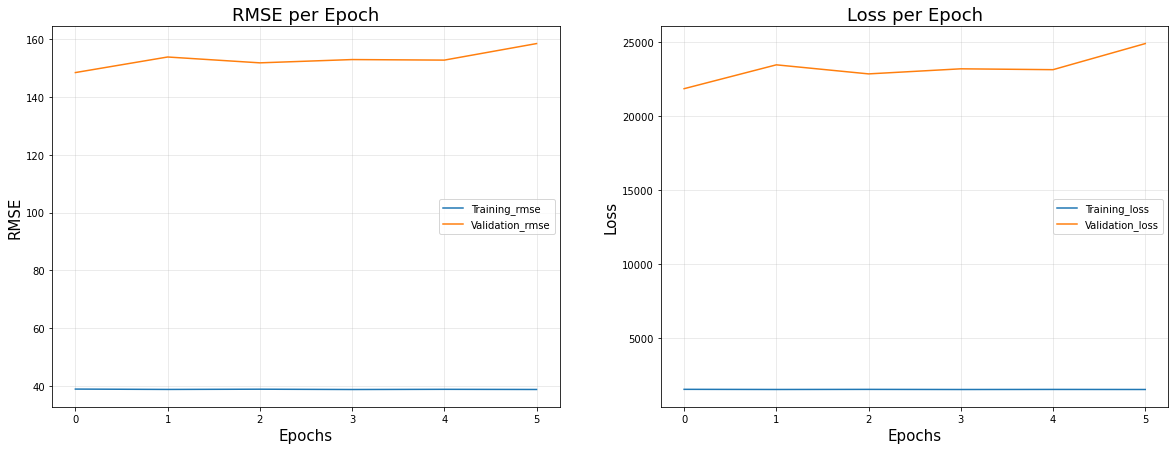

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 64
Epoch 1/50
33/39 [========================>.....] - ETA: 0s - loss: 1522.4316 - root_mean_squared_error: 39.0183
Epoch 1: val_loss improved from inf to 27087.38672, saving model to best_model_single_layer_lstm_experiment.h5
39/39 [==============================] - 0s 5ms/step - loss: 1502.2572 - root_mean_squared_error: 38.7590 - val_loss: 27087.3867 - val_root_mean_squared_error: 165.5807
Epoch 2/50
33/39 [========================>.....] - ETA: 0s - loss: 1513.8616 - 

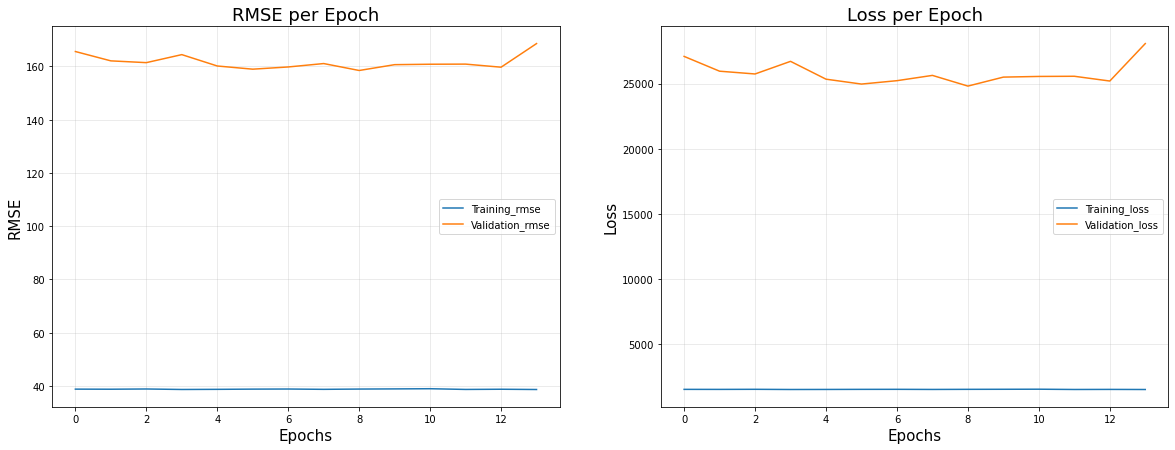

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 128
Epoch 1/50
13/20 [==================>...........] - ETA: 0s - loss: 1568.2930 - root_mean_squared_error: 39.6017
Epoch 1: val_loss improved from inf to 27280.91406, saving model to best_model_single_layer_lstm_experiment.h5
20/20 [==============================] - 0s 8ms/step - loss: 1501.0415 - root_mean_squared_error: 38.7780 - val_loss: 27280.9141 - val_root_mean_squared_error: 167.4809
Epoch 2/50
14/20 [====================>.........] - ETA: 0s - loss: 1503.5592 -

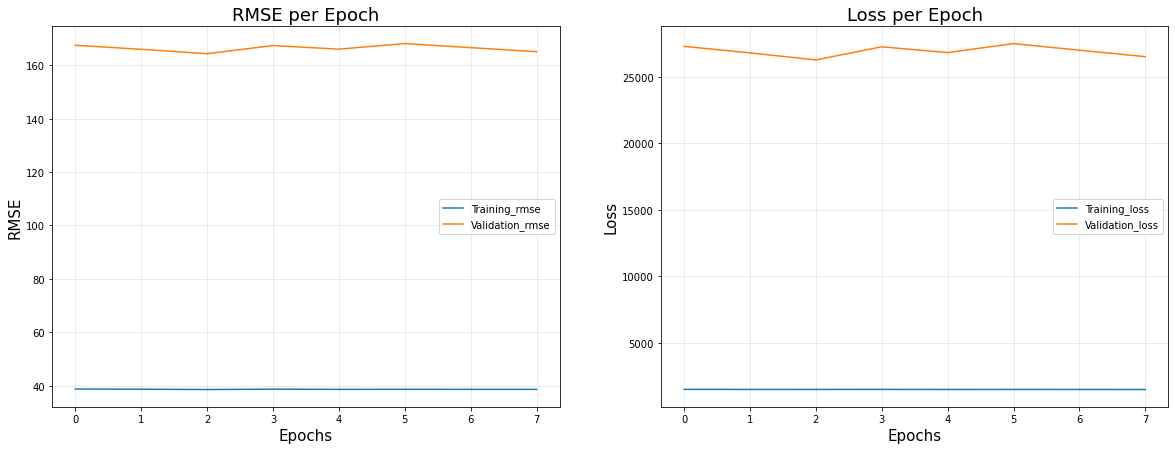

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 50
The Batch Size is: 256
Epoch 1/50
 1/10 [==>...........................] - ETA: 0s - loss: 1690.9923 - root_mean_squared_error: 41.1217
Epoch 1: val_loss improved from inf to 28628.87109, saving model to best_model_single_layer_lstm_experiment.h5
10/10 [==============================] - 0s 13ms/step - loss: 1490.2498 - root_mean_squared_error: 38.6478 - val_loss: 28628.8711 - val_root_mean_squared_error: 172.2519
Epoch 2/50
 1/10 [==>...........................] - ETA: 0s - loss: 1716.5016 

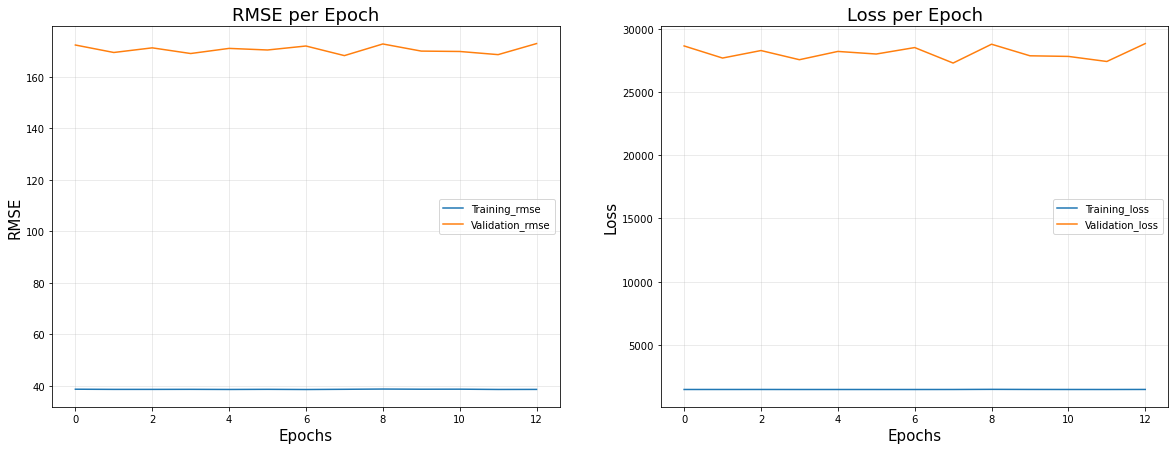

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 32
Epoch 1/100
56/78 [====================>.........] - ETA: 0s - loss: 1572.2438 - root_mean_squared_error: 39.6515
Epoch 1: val_loss improved from inf to 22426.69531, saving model to best_model_single_layer_lstm_experiment.h5
78/78 [==============================] - 0s 3ms/step - loss: 1515.6504 - root_mean_squared_error: 38.9314 - val_loss: 22426.6953 - val_root_mean_squared_error: 150.3070
Epoch 2/100
76/78 [============================>.] - ETA: 0s - loss: 1513.3794

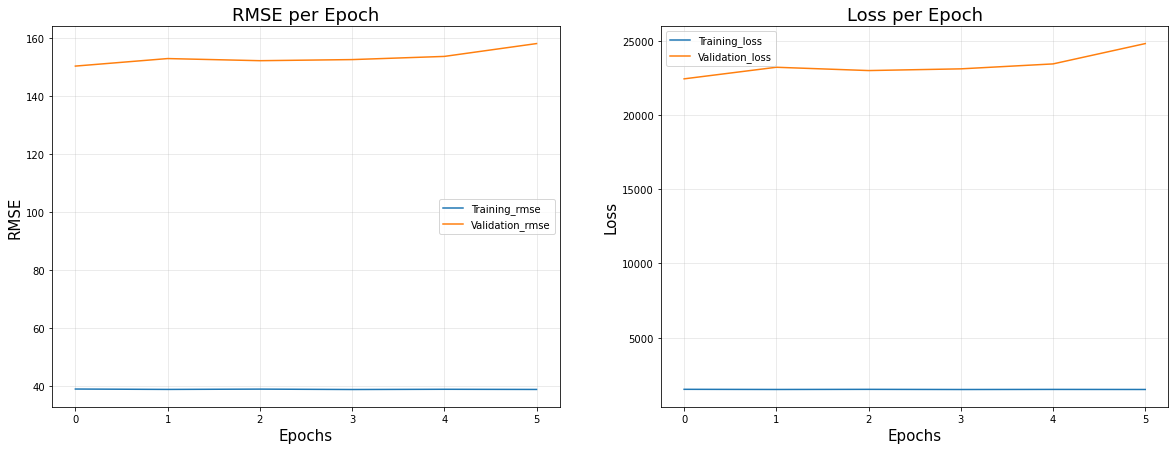

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 64
Epoch 1/100
37/39 [===========================>..] - ETA: 0s - loss: 1505.2493 - root_mean_squared_error: 38.7975
Epoch 1: val_loss improved from inf to 27373.10352, saving model to best_model_single_layer_lstm_experiment.h5
39/39 [==============================] - 0s 5ms/step - loss: 1499.6534 - root_mean_squared_error: 38.7254 - val_loss: 27373.1035 - val_root_mean_squared_error: 166.4518
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 1489.6064

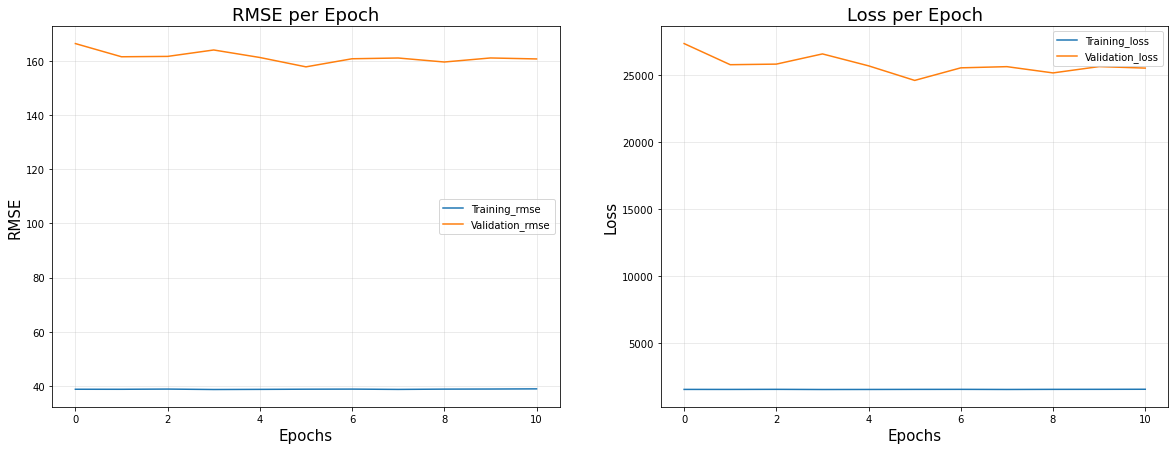

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 128
Epoch 1/100
14/20 [====================>.........] - ETA: 0s - loss: 1550.3486 - root_mean_squared_error: 39.3745
Epoch 1: val_loss improved from inf to 26729.80469, saving model to best_model_single_layer_lstm_experiment.h5
20/20 [==============================] - 0s 8ms/step - loss: 1494.1479 - root_mean_squared_error: 38.6900 - val_loss: 26729.8047 - val_root_mean_squared_error: 165.7813
Epoch 2/100
14/20 [====================>.........] - ETA: 0s - loss: 1502.847

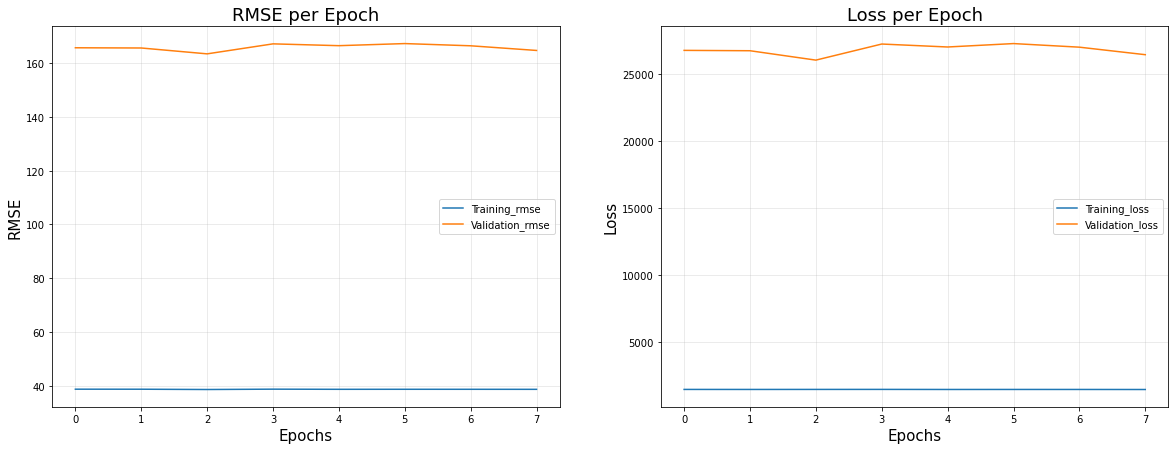

*****************************************************************************************************************

*****************************************************************************************************************
*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 100
The Batch Size is: 256
Epoch 1/100
 1/10 [==>...........................] - ETA: 0s - loss: 1689.0557 - root_mean_squared_error: 41.0981
Epoch 1: val_loss improved from inf to 28521.48828, saving model to best_model_single_layer_lstm_experiment.h5
10/10 [==============================] - 0s 12ms/step - loss: 1489.1934 - root_mean_squared_error: 38.6341 - val_loss: 28521.4883 - val_root_mean_squared_error: 171.9283
Epoch 2/100
 1/10 [==>...........................] - ETA: 0s - loss: 1716.00

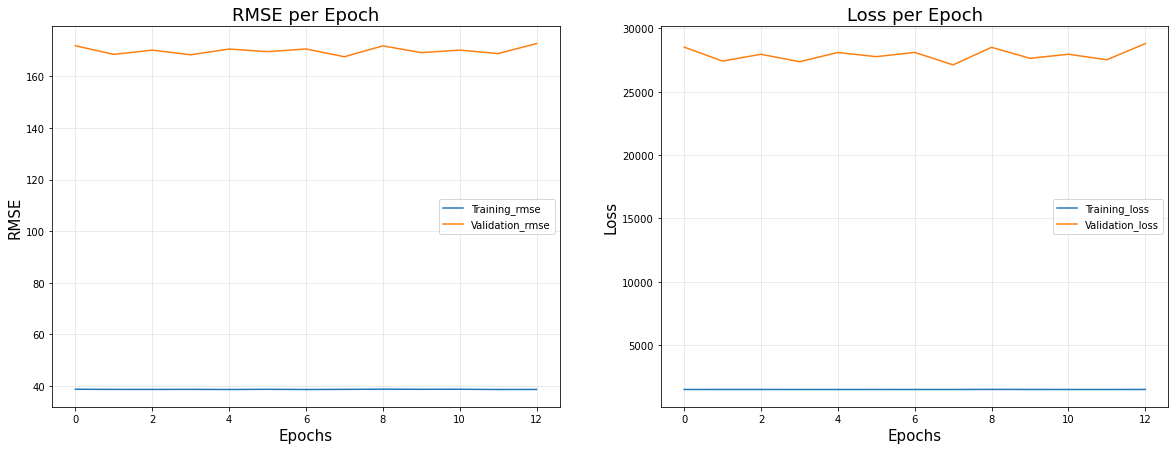

In [14]:
epochs=[10,20,50,100]
batch_sizes = [32,64,128,256]
for epoch in epochs:
    for batch_size in batch_sizes:  
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        mc = ModelCheckpoint('best_model_single_layer_lstm_experiment.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        # fit model
        
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print('The number of epoch for this experiment is:',epoch)
        print('The Batch Size is:',batch_size)
        Lstm_SingleLayer_Model_history = Lstm_SingleLayer_Model.fit(X_train, y_train, validation_split=0.3,
                                                                  epochs=epoch, batch_size=batch_size, callbacks=[es,mc])
        
        print()
        print('****************************************************************************************************************')
        print('The metrics score for epoch: {0}\nBatch Size: {1}\nRMSE for training set: {2}\nRMSE forValidation set: {3}\nLoss for Training set: {4}\nLoss for Validation set: {5}'
              .format(epoch,batch_size,mean(Lstm_SingleLayer_Model_history.history['root_mean_squared_error']),
        mean(Lstm_SingleLayer_Model_history.history['val_root_mean_squared_error']),
        mean( Lstm_SingleLayer_Model_history.history['loss']),mean(Lstm_SingleLayer_Model_history.history['val_loss'])))
        
       
        
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print()
        print('Comparative plot for RMSE per epoch and Loss per epoch for training and validation sets')
        print('*****************************************************************************************************************')
        print()
        
        
    
        
        
        fig = plt.figure(figsize=(20,7))
        fig.add_subplot(121)

        # RMSE per Epoch
        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['root_mean_squared_error'], label = "Training_rmse")
        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['val_root_mean_squared_error'], label = "Validation_rmse")

        plt.title("RMSE per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("RMSE", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()


        #Adding Subplot 1 (For Loss)
        fig.add_subplot(122)

        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['loss'], label="Training_loss")
        plt.plot(Lstm_SingleLayer_Model_history.epoch, Lstm_SingleLayer_Model_history.history['val_loss'], label="Validation_loss")

        plt.title("Loss per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("Loss", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()

        plt.show()

## 3. Bi-directional LSTM 

### c. Implementing the model <a class="anchor" id="section_3_3"></a>

In [15]:
# ------------------LSTM----------------------
Lstm_bidirectional_model = Sequential()
Lstm_bidirectional_model.add(Bidirectional(LSTM(activation='relu',units=128, return_sequences=True), 
                               input_shape=(X_train.shape[1], X_train.shape[2])))
Lstm_bidirectional_model.add(Dropout(0.2))

Lstm_bidirectional_model.add(Bidirectional(LSTM(activation='relu',units=128, return_sequences=False)))
Lstm_bidirectional_model.add(Dropout(0.2))
                                  
Lstm_bidirectional_model.add(Dense(units=1, activation='relu'))
Lstm_bidirectional_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.004), loss='mse', 
                              metrics=[tf.keras.metrics.RootMeanSquaredError()])

Lstm_bidirectional_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 3, 256)           133120    
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 3, 256)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 527,617
Trainable params: 527,617
Non-tr

### d. Training and evaluating the model <a class="anchor" id="section_3_4"></a>

*****************************************************************************************************************

*****************************************************************************************************************
The number of epoch for this experiment is: 10
The Batch Size is: 32
Epoch 1/10
75/78 [===========================>..] - ETA: 0s - loss: 179.4635 - root_mean_squared_error: 13.3964
Epoch 1: val_loss improved from inf to 559.32483, saving model to best_model_Bidirectional_layer_baseline.h5
78/78 [==============================] - 3s 13ms/step - loss: 174.5279 - root_mean_squared_error: 13.2109 - val_loss: 559.3248 - val_root_mean_squared_error: 23.6500
Epoch 2/10
74/78 [===========================>..] - ETA: 0s - loss: 50.9784 - root_mean_squared_error: 7.1399
Epoch 2: val_loss did not improve from 559.32483
78/78 [==============================] - 1s 8ms/step - loss: 51.9119 - root_mean_squared_error: 7.2050 - val_loss: 633.2059 - val_root_mean_squared_error: 2

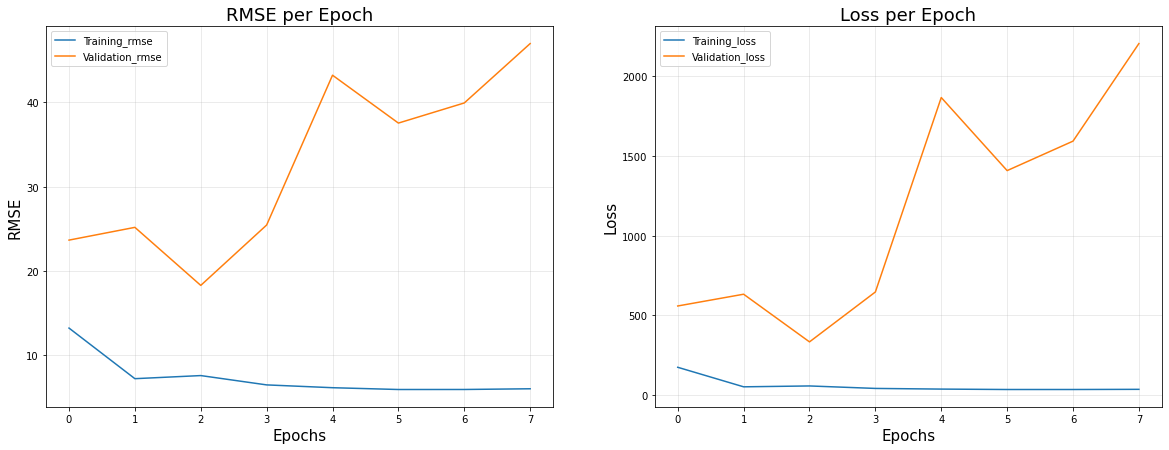

In [16]:
epochs=[10]
batch_sizes = [32]
for epoch in epochs:
    for batch_size in batch_sizes:  
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        mc = ModelCheckpoint('best_model_Bidirectional_layer_baseline.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        # fit model
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print('The number of epoch for this experiment is:',epoch)
        print('The Batch Size is:',batch_size)
        Lstm_Bidirectional_Model_history = Lstm_bidirectional_model.fit(X_train, y_train, validation_split=0.3,
                                                                  epochs=epoch, batch_size=batch_size, callbacks=[es,mc])
        
        
        
        
        print()
        print('****************************************************************************************************************')
        print('The metrics score for epoch: {0}\nBatch Size: {1}\nRMSE for training set: {2}\nRMSE forValidation set: {3}\nLoss for Training set: {4}\nLoss for Validation set: {5}'
              .format(epoch,batch_size,mean(Lstm_Bidirectional_Model_history.history['root_mean_squared_error']),
        mean(Lstm_Bidirectional_Model_history.history['val_root_mean_squared_error']),
        mean( Lstm_Bidirectional_Model_history.history['loss']),mean(Lstm_Bidirectional_Model_history.history['val_loss'])))
        
       
        
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print()
        print('Comparative plot for RMSE per epoch and Loss per epoch for training and validation sets')
        print('*****************************************************************************************************************')
        print()
        
       
        
        fig = plt.figure(figsize=(20,7))
        fig.add_subplot(121)

        # RMSE per Epoch
        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['root_mean_squared_error'], label = "Training_rmse")
        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['val_root_mean_squared_error'], label = "Validation_rmse")

        plt.title("RMSE per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("RMSE", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()


        #Adding Subplot 1 (For Loss)
        fig.add_subplot(122)

        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['loss'], label="Training_loss")
        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['val_loss'], label="Validation_loss")

        plt.title("Loss per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("Loss", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()

        plt.show()

# Experiment on the Baseline Model Bi-directional LSTM 
# with different number of epoch and Batch Size

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 10
The Batch Size is: 32
Epoch 1/10
78/78 [==============================] - ETA: 0s - loss: 39.0405 - root_mean_squared_error: 6.2482
Epoch 1: val_loss improved from inf to 2061.21948, saving model to best_model_bidirectional_lstm_experiment.h5
78/78 [==============================] - 1s 9ms/step - loss: 39.0405 - root_mean_squared_error: 6.2482 - val_loss: 2061.2195 - val_root_mean_squared_error: 45.4007
Epoch 2/10
75/78 [===========================>..] - ETA: 0s - loss: 30.4701 - root_mean_squared_error: 5.5200
Epoch 2: val_loss improved from 2061.21948 to 789.10364, saving model to best_model_bidirectional_lstm_experiment.h5
78/78 [==============================] - 1s 9ms/step - loss: 30.4173 - root_mean_squared_

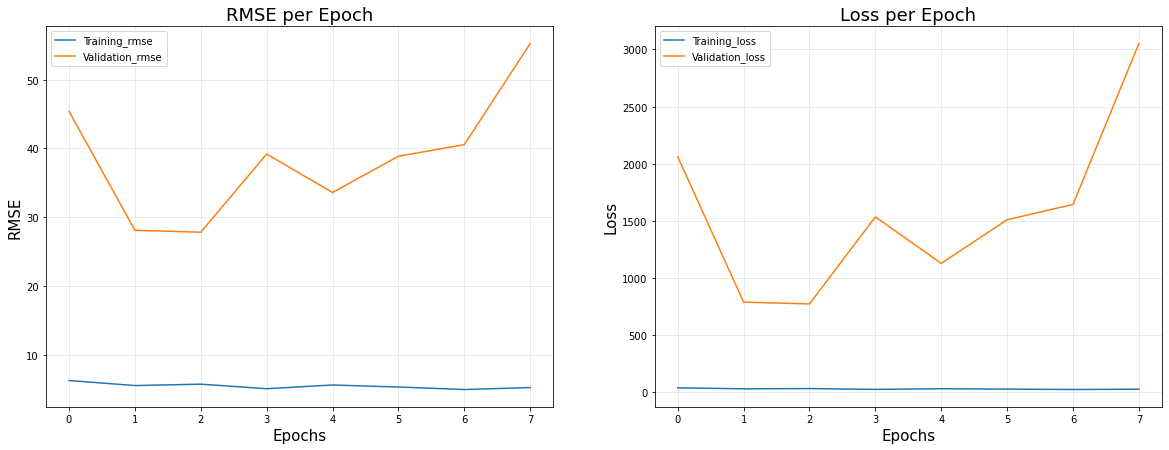

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 10
The Batch Size is: 64
Epoch 1/10
39/39 [==============================] - ETA: 0s - loss: 38.9391 - root_mean_squared_error: 6.2401
Epoch 1: val_loss improved from inf to 2173.72437, saving model to best_model_bidirectional_lstm_experiment.h5
39/39 [==============================] - 2s 13ms/step - loss: 38.9391 - root_mean_squared_error: 6.2401 - val_loss: 2173.7244 - val_root_mean_squared_error: 46.6232
Epoch 2/10
35/39 [=========================>....] - ETA: 0s - loss: 33.5684 - root_mean_squared_error: 5.7938
Epoch 2: val_loss improved from 2173.72437 to 1954.48389, saving model to best_model_bidirectional_lstm_experiment.h5
39/39 [==============================] - 0s 12ms/step - loss: 33.1809 - root_mean_squar

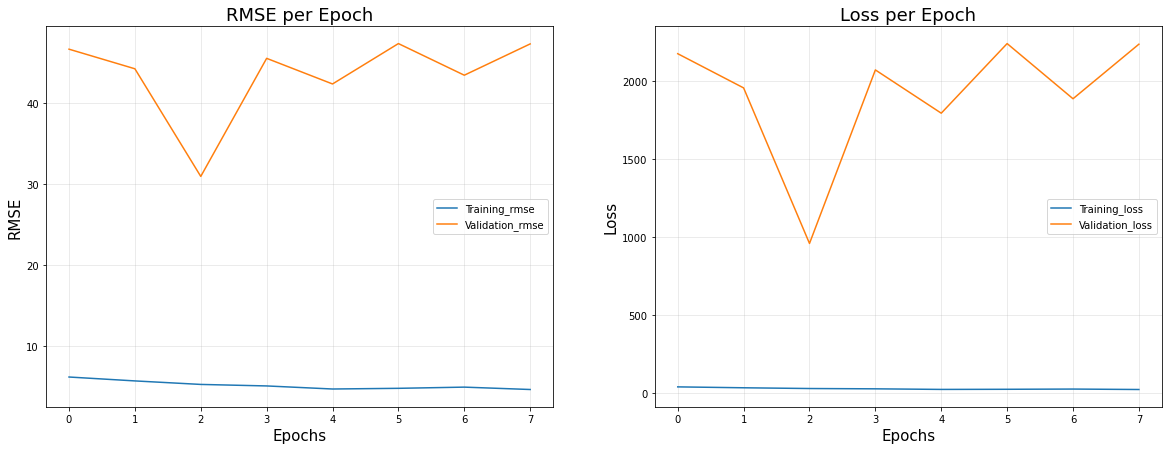

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 10
The Batch Size is: 128
Epoch 1/10
19/20 [===========================>..] - ETA: 0s - loss: 20.9838 - root_mean_squared_error: 4.5808
Epoch 1: val_loss improved from inf to 1932.79407, saving model to best_model_bidirectional_lstm_experiment.h5
20/20 [==============================] - 0s 18ms/step - loss: 20.8930 - root_mean_squared_error: 4.5709 - val_loss: 1932.7941 - val_root_mean_squared_error: 43.9636
Epoch 2/10
17/20 [========================>.....] - ETA: 0s - loss: 19.8096 - root_mean_squared_error: 4.4508
Epoch 2: val_loss did not improve from 1932.79407
20/20 [==============================] - 0s 16ms/step - loss: 20.0080 - root_mean_squared_error: 4.4730 - val_loss: 2012.4965 - val_root_mean_squared_erro

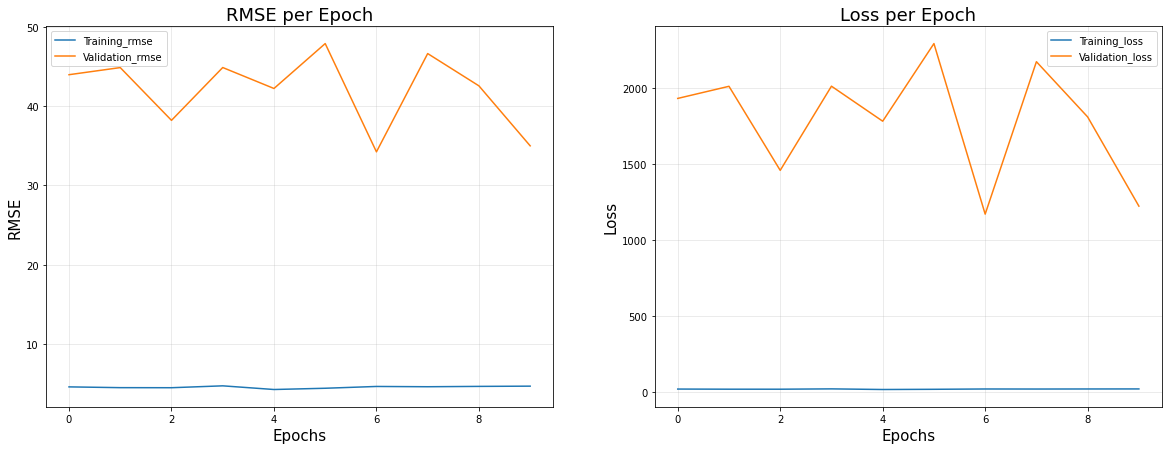

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 10
The Batch Size is: 256
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 23.9655 - root_mean_squared_error: 4.8955
Epoch 1: val_loss improved from inf to 2143.20654, saving model to best_model_bidirectional_lstm_experiment.h5
10/10 [==============================] - 0s 29ms/step - loss: 23.9655 - root_mean_squared_error: 4.8955 - val_loss: 2143.2065 - val_root_mean_squared_error: 46.2948
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 21.1221 - root_mean_squared_error: 4.5959
Epoch 2: val_loss did not improve from 2143.20654
10/10 [==============================] - 0s 25ms/step - loss: 21.1221 - root_mean_squared_error: 4.5959 - val_loss: 2146.7273 - val_root_mean_squared_erro

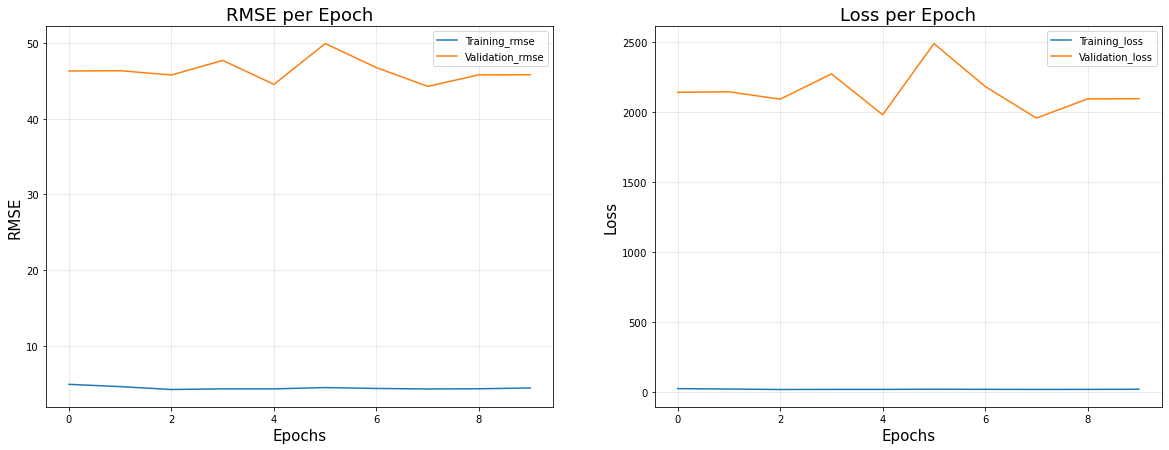

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 20
The Batch Size is: 32
Epoch 1/20
74/78 [===========================>..] - ETA: 0s - loss: 28.7493 - root_mean_squared_error: 5.3618
Epoch 1: val_loss improved from inf to 1728.99658, saving model to best_model_bidirectional_lstm_experiment.h5
78/78 [==============================] - 1s 9ms/step - loss: 28.5101 - root_mean_squared_error: 5.3395 - val_loss: 1728.9966 - val_root_mean_squared_error: 41.5812
Epoch 2/20
73/78 [===========================>..] - ETA: 0s - loss: 34.4111 - root_mean_squared_error: 5.8661
Epoch 2: val_loss did not improve from 1728.99658
78/78 [==============================] - 1s 8ms/step - loss: 34.0241 - root_mean_squared_error: 5.8330 - val_loss: 2394.7634 - val_root_mean_squared_error: 

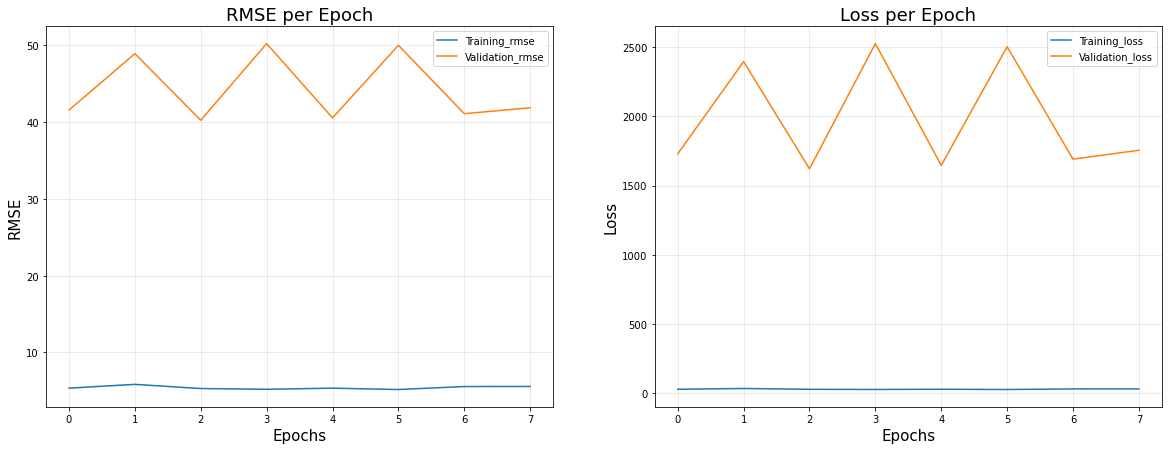

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 20
The Batch Size is: 64
Epoch 1/20
39/39 [==============================] - ETA: 0s - loss: 23.0217 - root_mean_squared_error: 4.7981
Epoch 1: val_loss improved from inf to 2215.67432, saving model to best_model_bidirectional_lstm_experiment.h5
39/39 [==============================] - 1s 13ms/step - loss: 23.0217 - root_mean_squared_error: 4.7981 - val_loss: 2215.6743 - val_root_mean_squared_error: 47.0709
Epoch 2/20
37/39 [===========================>..] - ETA: 0s - loss: 24.6360 - root_mean_squared_error: 4.9635
Epoch 2: val_loss did not improve from 2215.67432
39/39 [==============================] - 0s 12ms/step - loss: 24.5054 - root_mean_squared_error: 4.9503 - val_loss: 2635.0247 - val_root_mean_squared_error

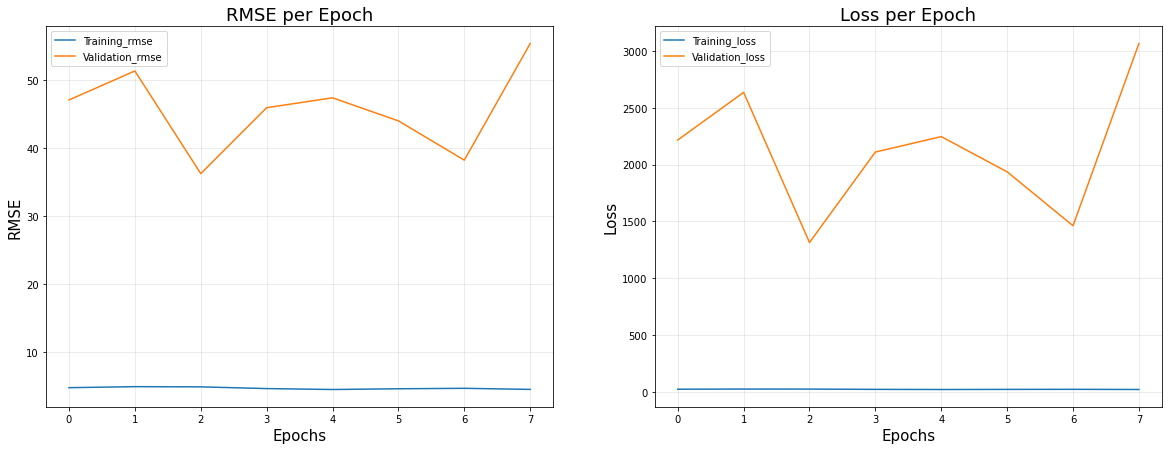

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 20
The Batch Size is: 128
Epoch 1/20
16/20 [=======================>......] - ETA: 0s - loss: 21.9141 - root_mean_squared_error: 4.6813
Epoch 1: val_loss improved from inf to 1792.26904, saving model to best_model_bidirectional_lstm_experiment.h5
20/20 [==============================] - 0s 17ms/step - loss: 22.5947 - root_mean_squared_error: 4.7534 - val_loss: 1792.2690 - val_root_mean_squared_error: 42.3352
Epoch 2/20
18/20 [==========================>...] - ETA: 0s - loss: 19.8686 - root_mean_squared_error: 4.4574
Epoch 2: val_loss did not improve from 1792.26904
20/20 [==============================] - 0s 16ms/step - loss: 19.4185 - root_mean_squared_error: 4.4066 - val_loss: 2447.1895 - val_root_mean_squared_erro

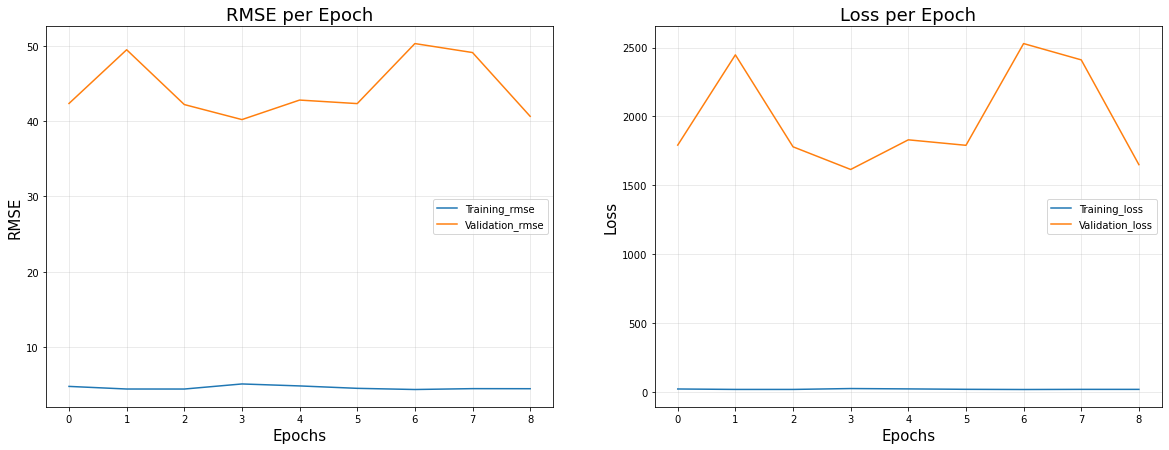

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 20
The Batch Size is: 256
Epoch 1/20
 7/10 [====================>.........] - ETA: 0s - loss: 20.8017 - root_mean_squared_error: 4.5609
Epoch 1: val_loss improved from inf to 1834.57019, saving model to best_model_bidirectional_lstm_experiment.h5
10/10 [==============================] - 0s 28ms/step - loss: 20.6704 - root_mean_squared_error: 4.5465 - val_loss: 1834.5702 - val_root_mean_squared_error: 42.8319
Epoch 2/20
 7/10 [====================>.........] - ETA: 0s - loss: 18.9473 - root_mean_squared_error: 4.3528
Epoch 2: val_loss did not improve from 1834.57019
10/10 [==============================] - 0s 22ms/step - loss: 18.7655 - root_mean_squared_error: 4.3319 - val_loss: 2305.2637 - val_root_mean_squared_erro

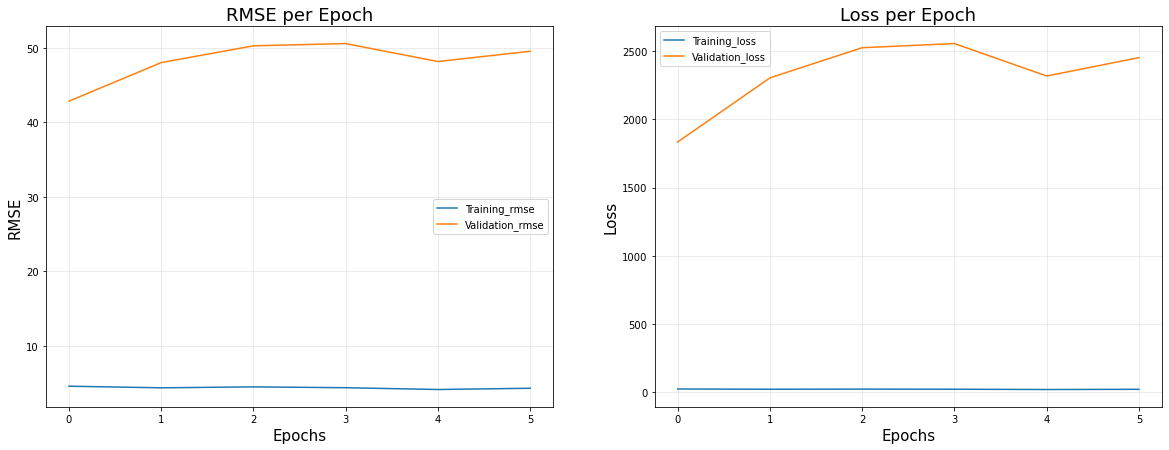

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 50
The Batch Size is: 32
Epoch 1/50
76/78 [============================>.] - ETA: 0s - loss: 20.6126 - root_mean_squared_error: 4.5401
Epoch 1: val_loss improved from inf to 2025.04529, saving model to best_model_bidirectional_lstm_experiment.h5
78/78 [==============================] - 1s 9ms/step - loss: 20.6222 - root_mean_squared_error: 4.5412 - val_loss: 2025.0453 - val_root_mean_squared_error: 45.0005
Epoch 2/50
73/78 [===========================>..] - ETA: 0s - loss: 22.7039 - root_mean_squared_error: 4.7649
Epoch 2: val_loss improved from 2025.04529 to 1312.44128, saving model to best_model_bidirectional_lstm_experiment.h5
78/78 [==============================] - 1s 8ms/step - loss: 22.9356 - root_mean_squared

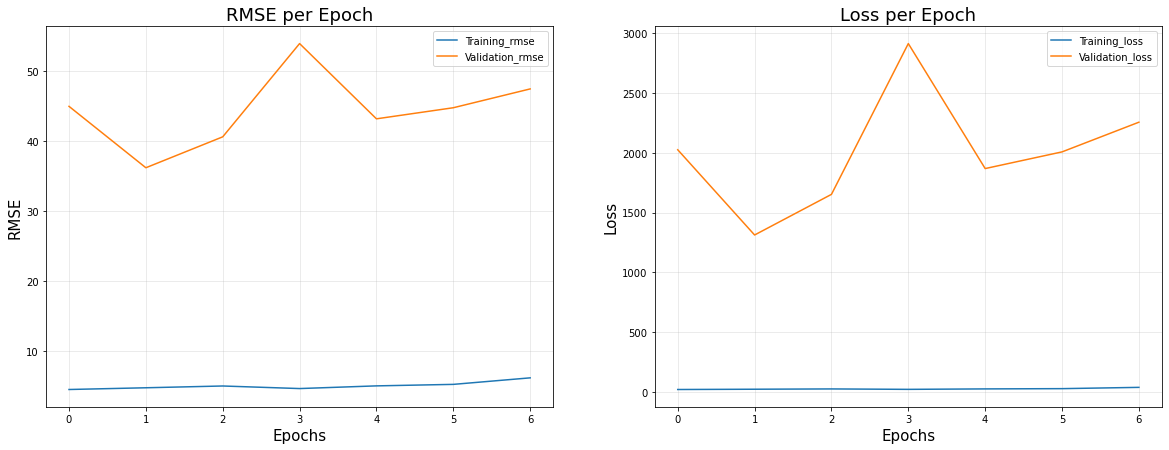

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 50
The Batch Size is: 64
Epoch 1/50
37/39 [===========================>..] - ETA: 0s - loss: 26.8889 - root_mean_squared_error: 5.1855
Epoch 1: val_loss improved from inf to 1791.49744, saving model to best_model_bidirectional_lstm_experiment.h5
39/39 [==============================] - 1s 13ms/step - loss: 26.6679 - root_mean_squared_error: 5.1641 - val_loss: 1791.4974 - val_root_mean_squared_error: 42.3261
Epoch 2/50
37/39 [===========================>..] - ETA: 0s - loss: 20.8622 - root_mean_squared_error: 4.5675
Epoch 2: val_loss did not improve from 1791.49744
39/39 [==============================] - 0s 12ms/step - loss: 20.7101 - root_mean_squared_error: 4.5508 - val_loss: 2905.5457 - val_root_mean_squared_error

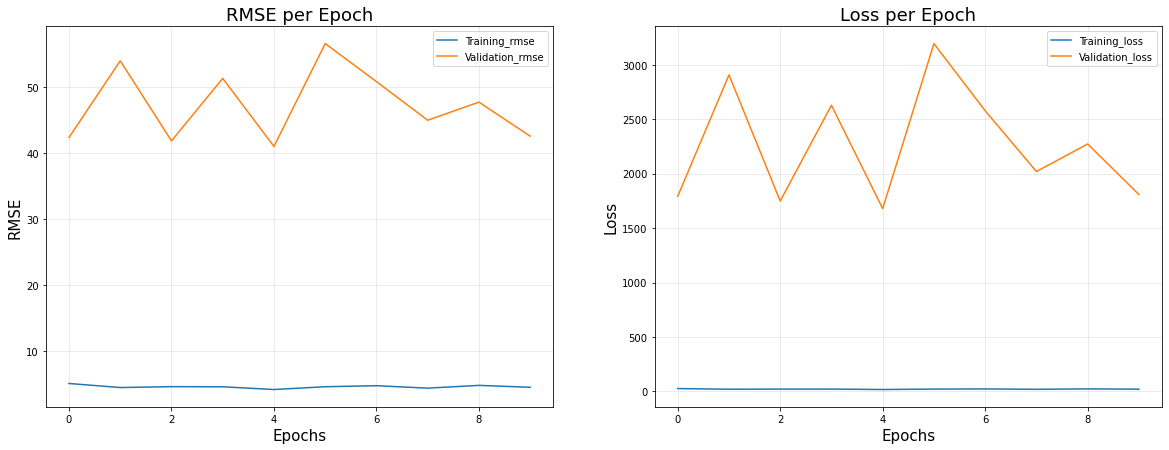

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 50
The Batch Size is: 128
Epoch 1/50
18/20 [==========================>...] - ETA: 0s - loss: 22.2318 - root_mean_squared_error: 4.7151
Epoch 1: val_loss improved from inf to 2080.06372, saving model to best_model_bidirectional_lstm_experiment.h5
20/20 [==============================] - 0s 19ms/step - loss: 22.1548 - root_mean_squared_error: 4.7069 - val_loss: 2080.0637 - val_root_mean_squared_error: 45.6077
Epoch 2/50
17/20 [========================>.....] - ETA: 0s - loss: 21.8432 - root_mean_squared_error: 4.6737
Epoch 2: val_loss did not improve from 2080.06372
20/20 [==============================] - 0s 16ms/step - loss: 22.2332 - root_mean_squared_error: 4.7152 - val_loss: 2608.8862 - val_root_mean_squared_erro

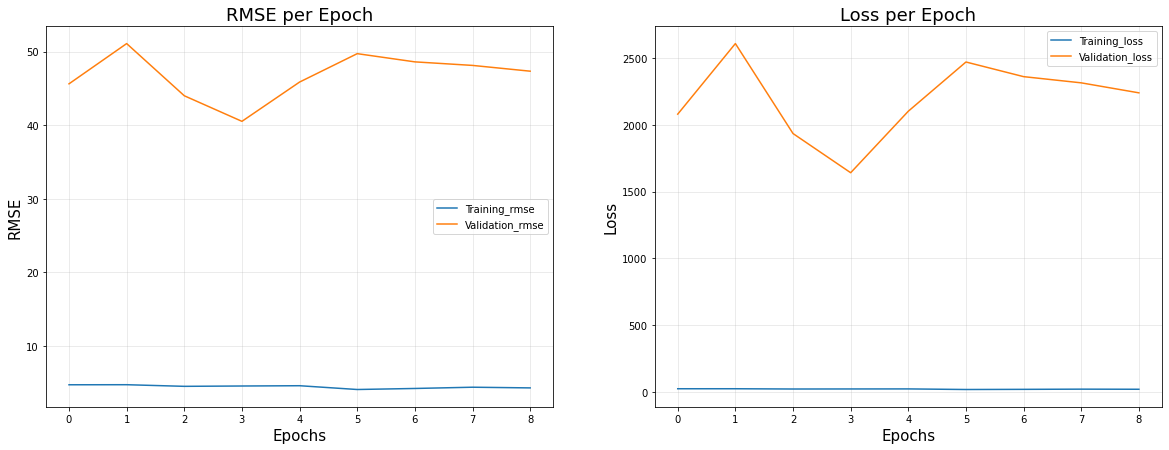

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 50
The Batch Size is: 256
Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 18.1683 - root_mean_squared_error: 4.2624
Epoch 1: val_loss improved from inf to 2577.42847, saving model to best_model_bidirectional_lstm_experiment.h5
10/10 [==============================] - 0s 28ms/step - loss: 18.1683 - root_mean_squared_error: 4.2624 - val_loss: 2577.4285 - val_root_mean_squared_error: 50.7684
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 17.6516 - root_mean_squared_error: 4.2014
Epoch 2: val_loss improved from 2577.42847 to 2290.95801, saving model to best_model_bidirectional_lstm_experiment.h5
10/10 [==============================] - 0s 30ms/step - loss: 17.6516 - root_mean_squa

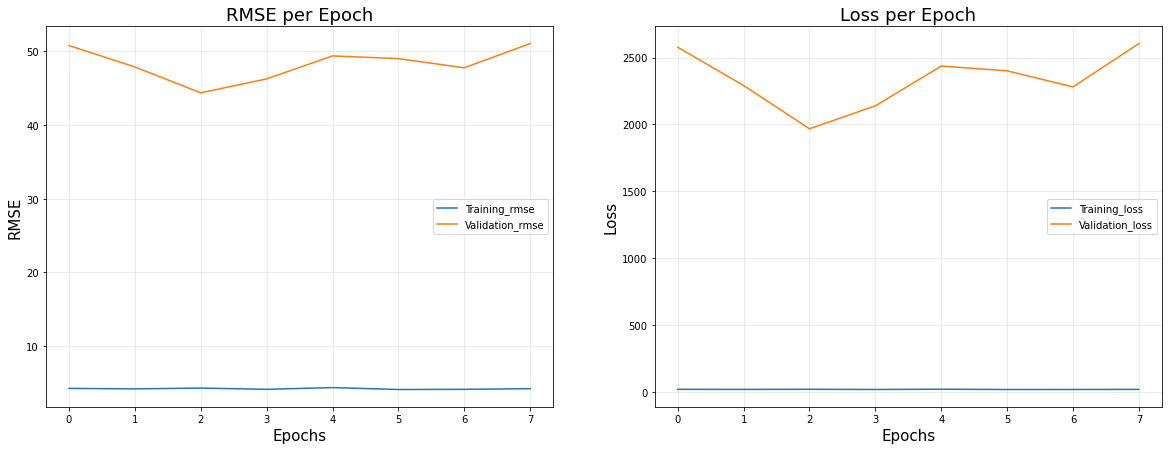

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 100
The Batch Size is: 32
Epoch 1/100
75/78 [===========================>..] - ETA: 0s - loss: 23.7155 - root_mean_squared_error: 4.8699
Epoch 1: val_loss improved from inf to 2590.07007, saving model to best_model_bidirectional_lstm_experiment.h5
78/78 [==============================] - 1s 9ms/step - loss: 23.8498 - root_mean_squared_error: 4.8836 - val_loss: 2590.0701 - val_root_mean_squared_error: 50.8927
Epoch 2/100
73/78 [===========================>..] - ETA: 0s - loss: 24.6899 - root_mean_squared_error: 4.9689
Epoch 2: val_loss did not improve from 2590.07007
78/78 [==============================] - 1s 8ms/step - loss: 24.4673 - root_mean_squared_error: 4.9464 - val_loss: 3519.4951 - val_root_mean_squared_erro

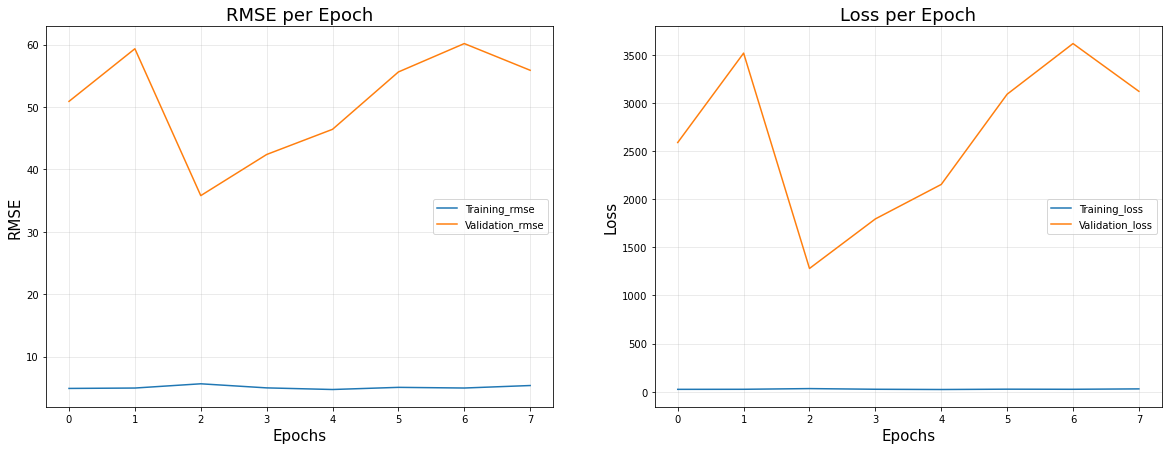

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 100
The Batch Size is: 64
Epoch 1/100
36/39 [==========================>...] - ETA: 0s - loss: 22.0613 - root_mean_squared_error: 4.6969
Epoch 1: val_loss improved from inf to 2041.97314, saving model to best_model_bidirectional_lstm_experiment.h5
39/39 [==============================] - 1s 14ms/step - loss: 21.6621 - root_mean_squared_error: 4.6543 - val_loss: 2041.9731 - val_root_mean_squared_error: 45.1882
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 19.6487 - root_mean_squared_error: 4.4327
Epoch 2: val_loss did not improve from 2041.97314
39/39 [==============================] - 0s 13ms/step - loss: 19.3363 - root_mean_squared_error: 4.3973 - val_loss: 3280.9648 - val_root_mean_squared_er

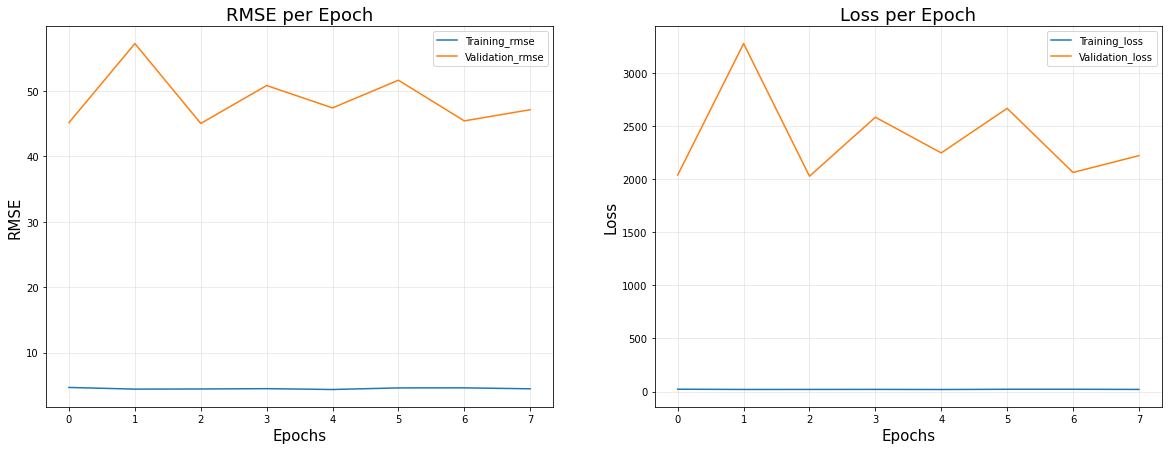

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 100
The Batch Size is: 128
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 18.7686 - root_mean_squared_error: 4.3323
Epoch 1: val_loss improved from inf to 2468.92017, saving model to best_model_bidirectional_lstm_experiment.h5
20/20 [==============================] - 0s 18ms/step - loss: 18.7686 - root_mean_squared_error: 4.3323 - val_loss: 2468.9202 - val_root_mean_squared_error: 49.6882
Epoch 2/100
18/20 [==========================>...] - ETA: 0s - loss: 18.9666 - root_mean_squared_error: 4.3551
Epoch 2: val_loss improved from 2468.92017 to 2323.47827, saving model to best_model_bidirectional_lstm_experiment.h5
20/20 [==============================] - 0s 17ms/step - loss: 19.6153 - root_mean_s

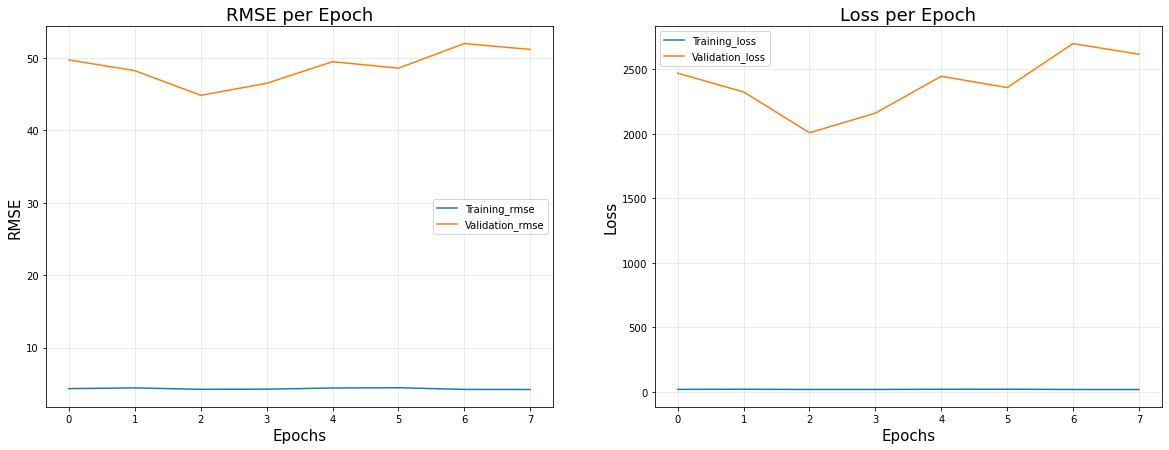

*****************************************************************************************************************

*****************************************************************************************************************

The number of epoch for this experiment is: 100
The Batch Size is: 256
Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 18.4367 - root_mean_squared_error: 4.2938
Epoch 1: val_loss improved from inf to 2544.39966, saving model to best_model_bidirectional_lstm_experiment.h5
10/10 [==============================] - 0s 31ms/step - loss: 18.4367 - root_mean_squared_error: 4.2938 - val_loss: 2544.3997 - val_root_mean_squared_error: 50.4420
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 16.6459 - root_mean_squared_error: 4.0799
Epoch 2: val_loss improved from 2544.39966 to 2222.71753, saving model to best_model_bidirectional_lstm_experiment.h5
10/10 [==============================] - 0s 30ms/step - loss: 16.6459 - root_mean_s

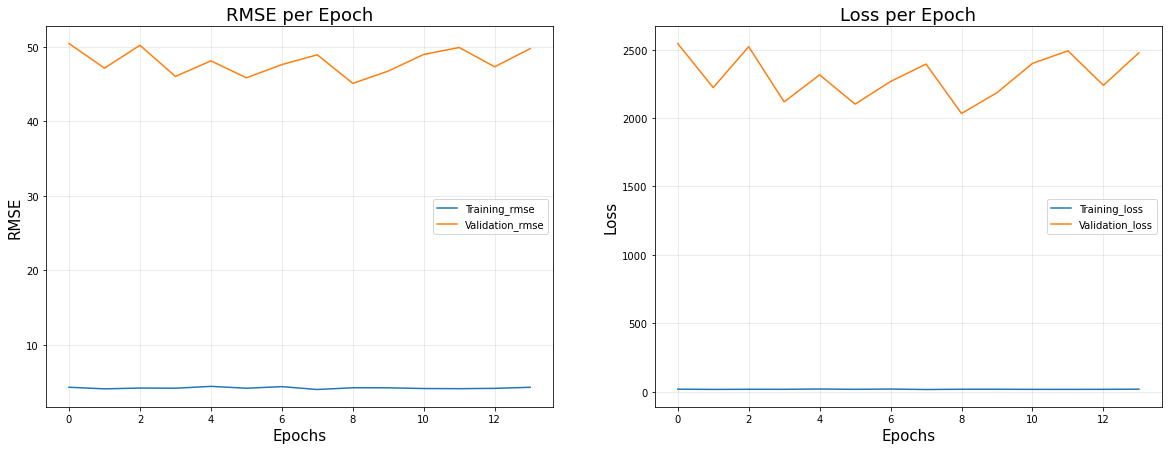

In [17]:
epochs=[10,20,50,100]
batch_sizes = [32,64,128,256]
for epoch in epochs:
    for batch_size in batch_sizes:  
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        mc = ModelCheckpoint('best_model_bidirectional_lstm_experiment.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        # fit model
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print()
        print('The number of epoch for this experiment is:',epoch)
        print('The Batch Size is:',batch_size)
        Lstm_Bidirectional_Model_history = Lstm_bidirectional_model.fit(X_train, y_train, validation_split=0.3,
                                                                  epochs=epoch, batch_size=batch_size, callbacks=[es,mc])
        
        
        print()
        print('****************************************************************************************************************')
        print('The metrics score for epoch: {0}\nBatch Size: {1}\nRMSE for training set: {2}\nRMSE forValidation set: {3}\nLoss for Training set: {4}\nLoss for Validation set: {5}'
              .format(epoch,batch_size,mean(Lstm_Bidirectional_Model_history.history['root_mean_squared_error']),
        mean(Lstm_Bidirectional_Model_history.history['val_root_mean_squared_error']),
        mean( Lstm_Bidirectional_Model_history.history['loss']),mean(Lstm_Bidirectional_Model_history.history['val_loss'])))
        
       
        
        print('*****************************************************************************************************************')
        print()
        print('*****************************************************************************************************************')
        print()
        print('Comparative plot for RMSE per epoch and Loss per epoch for training and validation sets')
        print('*****************************************************************************************************************')
        print()
        
       
        
        
        fig = plt.figure(figsize=(20,7))
        fig.add_subplot(121)

        # RMSE per Epoch
        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['root_mean_squared_error'], label = "Training_rmse")
        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['val_root_mean_squared_error'], label = "Validation_rmse")

        plt.title("RMSE per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("RMSE", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()


        #Adding Subplot 1 (For Loss)
        fig.add_subplot(122)

        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['loss'], label="Training_loss")
        plt.plot(Lstm_Bidirectional_Model_history.epoch, Lstm_Bidirectional_Model_history.history['val_loss'], label="Validation_loss")

        plt.title("Loss per Epoch", fontsize=18)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("Loss", fontsize=15)
        plt.grid(alpha=0.3)
        plt.legend()

        plt.show()

# Comparing the Baseline Model and Experiment Model

# Hyperparameter Tunning

In [15]:
#This is in contrast to the tuner approach where options for hyper parameters “hp” are specified and passed to the model

def build_model(hp):
    model = Sequential()

    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(Bidirectional(LSTM(hp.Int('input_unit'+ str(i),min_value=16,max_value=128,step=16),activation='relu',return_sequences=True)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Bidirectional(LSTM(hp.Int('input_unit'+ str(i),min_value=16,max_value=128,step=16),activation='relu', return_sequences=False)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(1))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    import keras
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model
    
tuner= kt.RandomSearch(
    hypermodel=build_model,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=3,
    executions_per_trial=3,
    overwrite=True,
    directory="LSTM_search",
    project_name="Search_result"
    )  


In [16]:
epoch=10
batch_size=64
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)       

file_path = 'best_model_lstm_selected.h5'

mc = tf.keras.callbacks.ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
tuner.search(
        x=X_train,
        y=y_train,
        epochs=epoch,
        batch_size=batch_size,
        validation_data=(X_train,y_train),validation_split=0.3, callbacks=[stop_early,mc]
)

Trial 3 Complete [00h 05m 53s]
val_loss: 3310.4722849527993

Best val_loss So Far: 232.35973612467447
Total elapsed time: 00h 11m 01s
INFO:tensorflow:Oracle triggered exit


In [37]:
tuner.results_summary()

Results summary
Results in LSTM_search\Search_result
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
num_layers: 12
input_unit0: 80
input_unit1: 32
Dropout_rate: 0.4
lr: 0.0013489304109835225
input_unit2: 16
input_unit3: 16
input_unit4: 16
input_unit5: 16
input_unit6: 16
input_unit7: 16
input_unit8: 16
input_unit9: 16
input_unit10: 16
input_unit11: 16
Score: 261.47581736246747


In [38]:
best_lstm_model = tf.keras.models.load_model('best_model_lstm_selected.h5')
best_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 3, 160)           52480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 64)            49408     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 3, 32)            10368     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 3, 32)            6272      
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 3, 32)            6

# Predictions 


In [33]:
from keras.models import load_model
# Load the saved model
result_Selected_model  = best_lstm_model.evaluate(X_test, y_test)
print("Loss for implemented model:", result_Selected_model[0])

# print("Test MAE for multi-layer baseline model:", result_Selected_model[1])

28/28 [==============================] - 1s 27ms/step - loss: 25.0235 - root_mean_squared_error: 5.0024
Loss for implemented model: 25.023540496826172


In [31]:
result_Selected_model

[25.023540496826172, 5.002353668212891]

In [24]:
X_test.shape

(892, 3, 1)

In [25]:
model=best_lstm_model
company='Yes Bank Ltd'

# Prediction
y_pred = model.predict(X_test)

# We create a dataframe from y_pred to have date-time indexes.
pred_data = pd.DataFrame(y_pred[:,0], dates_test,columns=['Close'])




28/28 [==============================] - 4s 28ms/step


In [26]:
# We create a dataframe from y_pred to have date-time indexes.
pred_data = pd.DataFrame(y_pred[:,0], index=dates_test,columns=['Predicted_close_price'])
y_test_df = pd.DataFrame(y_test, columns = ['Actual_close_price'], index = dates_test)
df_plot=pd.merge(y_test_df,pred_data, on=[dates_test])
df_plot_actual=df_plot.rename(columns={'key_0':'Date'})
df_plot_actual.set_index('Date',inplace=True)
df=df_plot_actual

df.head()

,Actual_close_price,Predicted_close_price
Date,,
2020-01-03,46.049999,58.254681
2020-01-06,47.299999,58.086323
2020-01-07,44.750000,58.981216
2020-01-08,42.099998,58.677414
2020-01-09,38.549999,56.950642


In [27]:
df.tail()

,Actual_close_price,Predicted_close_price
Date,,
2023-07-31,17.000000,20.135799
2023-08-01,16.950001,20.157373
2023-08-02,16.900000,20.108040
2023-08-03,16.850000,20.079491
2023-08-04,16.950001,20.031612


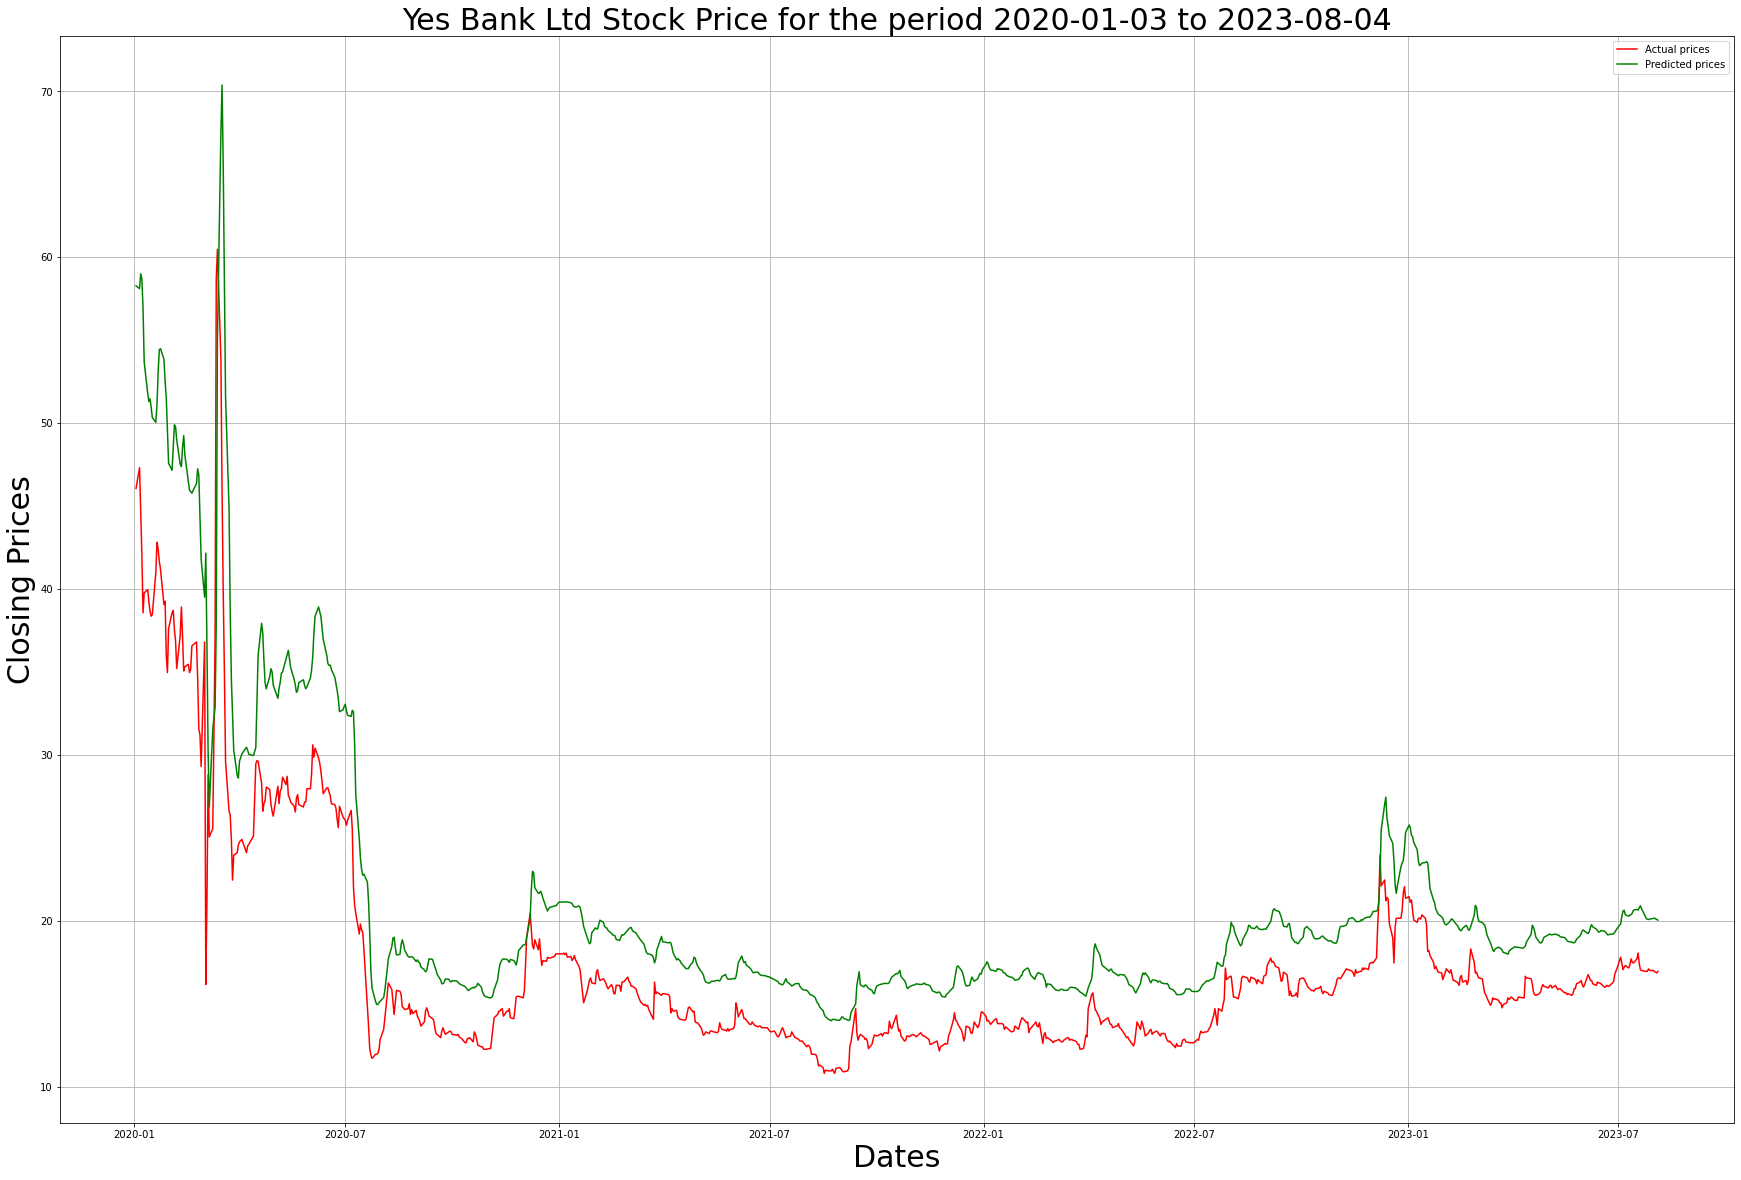

In [28]:
# Take the square, and the exponent
#pred_data = pred_data.apply(np.square)
#pred_data = pred_data.apply(np.exp)


# Plot actual prices vs predicted prices 
plt.figure(figsize=(30,20))
plt.grid(True)
plt.xlabel('Dates',fontsize = 30)
plt.ylabel('Closing Prices',fontsize = 30)
plt.plot(df['Actual_close_price'],'r',label='Actual prices')
plt.plot(df['Predicted_close_price'], 'g',label='Predicted prices')
plt.title(company + ' Stock Price for the period 2020-01-03 to 2023-08-04',fontsize = 30)

plt.legend(loc=0)